# Chem 277 Final Project: Virtual Screen for CFTR
## Qi Tifany Chu 
### Fall 2023

## Project Summary 
In this project, I will use an Artificial Neural Network and Random Forest Regressor to predict the binding affinities of ligands to the Cystic Fibrosis Transmembrane Receptor (CFTR). 

I will use the binding affinity data (EC50 and IC50) and SMILES strings from two sources: ChemBl and BindingDB. I will turn the smiles strings into Morgan Fingerprints and use that as the input for the Machine Learning Models. 

With my learned model, I then plan to recreate a Virtual Screen from a paper published by Sonawane et al. that contains similar ligands (active and inactive) of CFTR. This will allow me to asses the viability of my models and compare them. 

## Contents: This python notebook 

1) Download Data 
- Chembl Web 
- BindingPD 
2) Preprocess data 

- Combine Data Sets 
- Check for Missing Data & Duplicate Data 
- Turn SMILES into Fingerprints 
- Convert IC50/EC50 to pIC50/pEC50



3) Artificial Neural Network (ANN) model 

- Introduce Functions used for ANN (training and evaluation)
- Parameter Optimization 
- Running the models (Loss Curves)
- Model Evaluation (RMSE/MSE/R^2/Accuracy/Baseline)



4) Random Forest (RF) Regression Model 

- Optimize Parameters (GridSearchCV)
- Running the model (No Loss Curves in RF)
- Model Evaluation (RMSE/MSE/R^2/Accuracy/Baseline)
- Finding the important chemical motif contributors



5) Test Screen (Sonawane et al.)

- Preprocess Test Screen Data
- ANN Virtual Screen (VS)
- RF Virtual Screen 
- Compare with common motifs from RF 



6) Discusssion


7) References


(I ensured that the outline on code matches this ^^. )

In [557]:
# Import Packages 

# General use: 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import csv

# Data Preparation and Processing 

from chembl_webresource_client.new_client import new_client
import rdkit 
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import inchi 

# ANN 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split,KFold
from torch.optim import Adam, SGD
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

# Random Forest 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from rdkit.Chem import Draw

import warnings
warnings.filterwarnings('ignore')

# 1) Download Data
- got the CFTR ligands with known bioactivity info from ChemBL
- use web client to get data and make a csv file 

(This part might have been unncesssary to include but since I didn't use the ANI data set, I wanted to be sure you knew my process for gathering data. )

## Download Data: Chembl 

In [3]:
# read the file with the ids of the tested ligands with cftr 
# downloaded from ChemBL 
cftr = pd.read_csv("cftr.csv", sep=';')

# save the ids into a list called id 
id = cftr["Molecule ChEMBL ID"]

list(id)

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL1221483,NaN,NaN,486.93,1.0,5.00,PPQ-214,Cn1c(=O)c2c(-c3ccccc3F)n3c(c2n(C)c1=O)C(c1cccc...,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1221227,1,Scientific Literature,J Med Chem,2009.0,NaN,NaN,NaN
1,CHEMBL4085942,NaN,NaN,357.37,0.0,4.02,1e,O=c1c(-c2ccc([N+](=O)[O-])cc2)nc2ccccc2n1Cc1cc...,EC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL4007437,1,Scientific Literature,J Med Chem,2017.0,NaN,NaN,NaN
2,CHEMBL75680,ALOISINE A,NaN,267.33,0.0,3.67,"K00059, Aloisine",CCCCc1c(-c2ccc(O)cc2)[nH]c2nccnc12,EC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1145498,1,Scientific Literature,Proc Natl Acad Sci U S A,2007.0,NaN,NaN,NaN
3,CHEMBL4176184,NaN,NaN,418.95,1.0,6.16,VRT-768,O=C(Nc1ncc(Cc2ccccc2Cl)s1)C(c1ccccc1)c1ccccc1,EC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL4145449,1,Scientific Literature,Eur J Med Chem,2018.0,NaN,NaN,NaN
4,CHEMBL1222337,NaN,NaN,464.53,0.0,4.22,PPQ-204,COc1cccc(C2Nc3ccccc3-n3c(-c4ccccc4)c4c(=O)n(C)...,IC50,'=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1221227,1,Scientific Literature,J Med Chem,2009.0,NaN,NaN,NaN


In [5]:
# SAVE IC50 DATA to cftr_ic50.csv 

# Initialize the clients for molecule and activity
molecule = new_client.molecule
activity = new_client.activity

# Specify the target ChEMBL ID for the CFTR protein
target_chembl_id = 'CHEMBL4051'  

# List of compound ChEMBL IDs
compound_ids = id  

# File to save the compound data with bioactivity
output_file = 'cftr_IC50.csv'

# Open the CSV file for writing
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row
    writer.writerow(['Compound ChEMBL ID', 'Bioactivity Type', 'Bioactivity Value (nM)', 'Molecular Formula', 'SMILES'])

    for compound_id in compound_ids:
        # the bioactivity data for the compound against the target
        bioactivities = activity.filter(molecule_chembl_id=compound_id).filter(target_chembl_id=target_chembl_id)
        
        for bioactivity in bioactivities:
            if bioactivity['standard_type'] in ('IC50', 'Ki', 'Kd') and bioactivity['standard_units'] == 'nM':
                # the compound's structural data
                compound_info = molecule.get(compound_id)
                writer.writerow([
                    compound_id,
                    bioactivity['standard_type'],
                    bioactivity['standard_value'],
                    compound_info['molecule_properties']['full_molformula'],
                    compound_info['molecule_structures']['canonical_smiles']
                ])


In [21]:
# SAVE EC50 DATA to cftr_ec50.csv 

# Initialize the clients for molecule and activity
molecule = new_client.molecule
activity = new_client.activity

# Specify the target ChEMBL ID for the CFTR protein
target_chembl_id = 'CHEMBL4051'  

# List of compound ChEMBL IDs
compound_ids = id  

# File to save the compound data with bioactivity
output_file = 'cftr_ec50.csv'

# Open the CSV file for writing
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row
    writer.writerow(['Compound ChEMBL ID', 'Bioactivity Type', 'Bioactivity Value (nM)', 'Molecular Formula', 'SMILES'])
    # use IC50+Ec50 + convert Ki
    # Chembl Act --> comparable 

    for compound_id in compound_ids:
        # Fetch the bioactivity data for the compound against the target
        bioactivities = activity.filter(molecule_chembl_id=compound_id).filter(target_chembl_id=target_chembl_id)
        
        for bioactivity in bioactivities:
            if bioactivity['standard_type'] in ('EC50') and bioactivity['standard_units'] == 'nM':
                # Fetch the compound's structural data
                compound_info = molecule.get(compound_id)
                writer.writerow([
                    compound_id,
                    bioactivity['standard_type'],
                    bioactivity['standard_value'],
                    compound_info['molecule_properties']['full_molformula'],
                    compound_info['molecule_structures']['canonical_smiles']
                ])

In [222]:
# load the ec50 data set 
ic50 = pd.read_csv("cftr_ic50.csv")


print(f"original size of ic50 = {len(ic50)}")
ic50.head(5)

print(ic50["Bioactivity Type"].value_counts())

# load the ec50 data set 
ec50 = pd.read_csv("cftr_ec50.csv")
print("ec50")
ec50_orginial = pd.read_csv("cftr_ec50.csv")
print(ec50["Bioactivity Type"].value_counts())

print(f"original size of ec50 = {len(ec50)}")
ec50.head(5)
ic50.head(5)

original size of ic50 = 182
Bioactivity Type
IC50    146
Kd       34
Ki        2
Name: count, dtype: int64
ec50
Bioactivity Type
EC50    1278
Name: count, dtype: int64
original size of ec50 = 1278


,Compound ChEMBL ID,Bioactivity Type,Bioactivity Value (nM),Molecular Formula,SMILES
0,CHEMBL1221483,IC50,2500.0,C27H20ClFN4O2,Cn1c(=O)c2c(-c3ccccc3F)n3c(c2n(C)c1=O)C(c1cccc...
1,CHEMBL1222337,IC50,1700.0,C28H24N4O3,COc1cccc(C2Nc3ccccc3-n3c(-c4ccccc4)c4c(=O)n(C)...
2,CHEMBL1221533,IC50,8000.0,C28H23FN4O2,Cc1cccc(-c2c3c(=O)n(C)c(=O)n(C)c3c3n2-c2ccccc2...
3,CHEMBL461939,IC50,380.0,C18H10F3NO3S2,O=C(O)c1ccc(/C=C2\SC(=S)N(c3cccc(C(F)(F)F)c3)C...
4,CHEMBL461939,IC50,300.0,C18H10F3NO3S2,O=C(O)c1ccc(/C=C2\SC(=S)N(c3cccc(C(F)(F)F)c3)C...


## Download Data:  BindingDB data 

In [221]:
# More EC/IC50 data from binding DB 
bindingDB = pd.read_csv("bindingdb_cftr2.tsv", sep= '\t')

print(f"Number of CFTR ligands in Binding DB = {len(bindingDB)}")

#print(bindingDB.columns)

# make subset with columns of interest 
bindingDB_subset = bindingDB[['ChEMBL ID of Ligand', 'Ligand SMILES', 'IC50 (nM)' ,'EC50 (nM)', 'BindingDB Reactant_set_id']]

bindingDB_subset['Data_Source'] = "bindingDB"
bindingDB_subset.rename(columns = {'Ligand SMILES': 'SMILES'} , inplace=True)

bindingDB_subset.head()


Number of CFTR ligands in Binding DB = 1143


/var/folders/32/pzd9lc0s5rz_7tl6nx6q4nn40000gn/T/ipykernel_44421/2548164350.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bindingDB_subset['Data_Source'] = "bindingDB"
/var/folders/32/pzd9lc0s5rz_7tl6nx6q4nn40000gn/T/ipykernel_44421/2548164350.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bindingDB_subset.rename(columns = {'Ligand SMILES': 'SMILES'} , inplace=True)


,ChEMBL ID of Ligand,SMILES,IC50 (nM),EC50 (nM),BindingDB Reactant_set_id,Data_Source
0,CHEMBL28,Oc1ccc(cc1)-c1cc(=O)c2c(O)cc(O)cc2o1,NaN,NaN,50278004,bindingDB
1,NaN,Cn1c2c3[C@@H](O[C@@H](CO)Cn3c(-c3cccc(F)c3)c2c...,0.05,NaN,388438,bindingDB
2,NaN,Cn1c2c3[C@H](O[C@@H](CO)Cn3c(-c3cccc(Cl)c3)c2c...,0.07,NaN,388442,bindingDB
3,NaN,Cc1csc(n1)-c1n2CC(CO)OC(c3ccc(Cl)o3)c2c2n(C)c(...,0.09,NaN,388440,bindingDB
4,NaN,Cn1c2c3[C@@H](O[C@@H](CO)Cn3c(-c3cccc(Cl)c3)c2...,0.12,NaN,388443,bindingDB


In [225]:
# Find columns with IC or EC50 values 

# make a subset of the data with IC50
bindingDB_IC = bindingDB_subset.dropna(subset = ['IC50 (nM)'])

# rename to match CHEMBL data 
bindingDB_IC["Bioactivity Type"] = "IC50"
bindingDB_IC.rename(columns = {'IC50 (nM)': 'Bioactivity Value (nM)'} , inplace=True)
bindingDB_IC = bindingDB_IC.drop(columns=['EC50 (nM)'])

# make a subset of the data with EC50
bindingDB_EC = bindingDB_subset.dropna(subset = ['EC50 (nM)'])

# rename to match CHEMBL data 
bindingDB_EC["Bioactivity Type"] = "EC50"
bindingDB_EC.rename(columns = {'EC50 (nM)': 'Bioactivity Value (nM)'} , inplace=True)
bindingDB_EC = bindingDB_EC.drop(columns=['IC50 (nM)'])

#df = bindingDB.drop(bindingDB[(bindingDB['IC50 (nM)'].isna()) & (bindingDB['EC50 (nM)'].isna())].index)

print(f"Number of CFTR ligands in Binding DB with IC50 values = {len(bindingDB_IC)}")
print(f"Number of CFTR ligands in Binding DB with EC50 values = {len(bindingDB_EC)}")
print(f"Number of CFTR ligands in Binding DB with EC50 or IC50 values = {len(bindingDB_EC)+len(bindingDB_IC)}")

bindingDB_EC.head()

Number of CFTR ligands in Binding DB with IC50 values = 197
Number of CFTR ligands in Binding DB with EC50 values = 904
Number of CFTR ligands in Binding DB with EC50 or IC50 values = 1101


,ChEMBL ID of Ligand,SMILES,Bioactivity Value (nM),BindingDB Reactant_set_id,Data_Source,Bioactivity Type
50,NaN,CC(C)(C)c1cc2c(C#N)c(NC(=O)C3(CC3)c3ccc4OC(F)(...,284,535690,bindingDB,EC50
51,NaN,CC1(C)CCn2c1cc1cc(NC(=O)C3(CC3)c3ccc4OC(F)(F)O...,228,535691,bindingDB,EC50
52,NaN,CC(C)(CO)c1cc2cc(NC(=O)C3(CC3)c3ccc4OC(F)(F)Oc...,272,535692,bindingDB,EC50
53,NaN,CC(C)(CCOC[C@@H](O)CO)c1cc2cc(NC(=O)C3(CC3)c3c...,285,535693,bindingDB,EC50
54,NaN,COc1ccc(cc1)C1(CC1(C)C)C(=O)Nc1ccc2[nH]c(cc2c1...,4525,535694,bindingDB,EC50


# 2) Preprocess Data 

- combine Chembl and bindingPD data 
- remove duplicates and missing data. 
- convert SMILES to molecular fingerprints. 
- convert IC50 and EC50 data to pIC50 and pEC50

Note that since I am interested in Binding Affinities, it doesn't really matter if its an activator or inhibitor as I am just concerned with finding ligands that have high binding affinities for CFTR. Hence, a low IC50/EC50 and similarly, a high pIC50/pEC50 implies that the ligands have a strong affinity for CFTR. 


### Preprocess Data : Combine Datasets 

- Into variable --> cftr_all
- post processing saved csv --> processed_table1.csv

In [227]:
# combine the CHEMBL data 
ec50 = pd.read_csv("cftr_ec50.csv")
ic50 = pd.read_csv("cftr_ic50.csv")

# create combined data frame. 
chembl_data= pd.concat([ec50,ic50])

# add data_source column
chembl_data["Data_Source"] = "CHEMBL"
chembl_data["BindingDB Reactant_set_id"] = None

chembl_data.to_csv("chembl_merged.csv", index=False)
chembl_data.head()

,Compound ChEMBL ID,Bioactivity Type,Bioactivity Value (nM),Molecular Formula,SMILES,Data_Source,BindingDB Reactant_set_id
0,CHEMBL4085942,EC50,1000.0,C21H15N3O3,O=c1c(-c2ccc([N+](=O)[O-])cc2)nc2ccccc2n1Cc1cc...,CHEMBL,None
1,CHEMBL75680,EC50,150.0,C16H17N3O,CCCCc1c(-c2ccc(O)cc2)[nH]c2nccnc12,CHEMBL,None
2,CHEMBL75680,EC50,140.0,C16H17N3O,CCCCc1c(-c2ccc(O)cc2)[nH]c2nccnc12,CHEMBL,None
3,CHEMBL75680,EC50,111.0,C16H17N3O,CCCCc1c(-c2ccc(O)cc2)[nH]c2nccnc12,CHEMBL,None
4,CHEMBL4176184,EC50,7900.0,C24H19ClN2OS,O=C(Nc1ncc(Cc2ccccc2Cl)s1)C(c1ccccc1)c1ccccc1,CHEMBL,None


In [207]:
# combine the bindingPD data 
bindingDB_all = pd.concat([bindingDB_IC, bindingDB_EC])

# add columns/ reoder columns so that it matches the Chembl data 
bindingDB_all["Molecular Formula"] = None
bindingDB_all = bindingDB_all[["ChEMBL ID of Ligand", "Bioactivity Type", "Bioactivity Value (nM)", "Molecular Formula", "SMILES", "Data_Source", "BindingDB Reactant_set_id"]]
bindingDB_all.rename(columns = {'ChEMBL ID of Ligand': "Compound ChEMBL ID"} , inplace=True)

bindingDB_all.head()

,Compound ChEMBL ID,Bioactivity Type,Bioactivity Value (nM),Molecular Formula,SMILES,Data_Source,BindingDB Reactant_set_id
1,NaN,IC50,0.05,None,Cn1c2c3[C@@H](O[C@@H](CO)Cn3c(-c3cccc(F)c3)c2c...,bindingDB,388438
2,NaN,IC50,0.07,None,Cn1c2c3[C@H](O[C@@H](CO)Cn3c(-c3cccc(Cl)c3)c2c...,bindingDB,388442
3,NaN,IC50,0.09,None,Cc1csc(n1)-c1n2CC(CO)OC(c3ccc(Cl)o3)c2c2n(C)c(...,bindingDB,388440
4,NaN,IC50,0.12,None,Cn1c2c3[C@@H](O[C@@H](CO)Cn3c(-c3cccc(Cl)c3)c2...,bindingDB,388443
5,NaN,IC50,0.24,None,COCC1Cn2c(C(O1)c1ccc(Cl)o1)c1n(C)c(=O)n(C)c(=O...,bindingDB,388448


In [259]:
# Combine the datasets 
# FULL DATA !!! 
cftr_all = pd.concat([chembl_data, bindingDB_all])
cftr_all.head()

,Compound ChEMBL ID,Bioactivity Type,Bioactivity Value (nM),Molecular Formula,SMILES,Data_Source,BindingDB Reactant_set_id
0,CHEMBL4085942,EC50,1000.0,C21H15N3O3,O=c1c(-c2ccc([N+](=O)[O-])cc2)nc2ccccc2n1Cc1cc...,CHEMBL,None
1,CHEMBL75680,EC50,150.0,C16H17N3O,CCCCc1c(-c2ccc(O)cc2)[nH]c2nccnc12,CHEMBL,None
2,CHEMBL75680,EC50,140.0,C16H17N3O,CCCCc1c(-c2ccc(O)cc2)[nH]c2nccnc12,CHEMBL,None
3,CHEMBL75680,EC50,111.0,C16H17N3O,CCCCc1c(-c2ccc(O)cc2)[nH]c2nccnc12,CHEMBL,None
4,CHEMBL4176184,EC50,7900.0,C24H19ClN2OS,O=C(Nc1ncc(Cc2ccccc2Cl)s1)C(c1ccccc1)c1ccccc1,CHEMBL,None


### Preprocess Data: Size of combined 

In [260]:
# Find Lengths of source 

print(f"size of Chembl data: {len(chembl_data)}")

print(f"\nsize of BindingDB data: {len(bindingDB_all)}")

print(f"\nsize of cftr_all (full data set): {len(cftr_all)}")

size of Chembl data: 1460

size of BindingDB data: 1101

size of cftr_all (full data set): 2561


### Preprocess Data: only Ec50 and Ic50
- cftr size before: 2561

- cftr size after: 2525

In [261]:
# Remove those that are not EC50 or IC50 values 

print(f"number of Ligands after merging:{len(cftr_all)}") 
cftr_all.head(5)
print("Bioactivity types before deletion:")
#save only ec50 and ic50 types. 
print(cftr_all["Bioactivity Type"].value_counts())

cftr_all = cftr_all[(cftr_all["Bioactivity Type"]== "EC50")| (cftr_all["Bioactivity Type"]== "IC50")]

print("")
print(f"number of ligands (with ec or ic 50 data):{len(cftr_all)}") 
print("Bioactivity types after deletion:")
print(cftr_all["Bioactivity Type"].value_counts())

number of Ligands after merging:2561
Bioactivity types before deletion:
Bioactivity Type
EC50    2182
IC50     343
Kd        34
Ki         2
Name: count, dtype: int64

number of ligands (with ec or ic 50 data):2525
Bioactivity types after deletion:
Bioactivity Type
EC50    2182
IC50     343
Name: count, dtype: int64


### 2) Preprocess Data : Check for Missing Data 
No missing data 

- cftr size before: 2525

- cftr size after: 2525

No missing data in SMILES or bioactivity value. 

In [262]:
# Preprocessing data 

# check for missing data 
missing = cftr_all.isnull().sum()
print(missing) 

print(f"\n size of cftr_all: {len(cftr_all)}")

# No missing data for columns of interest (Bioactvity Type/Values, SMILES)

Compound ChEMBL ID            782
Bioactivity Type                0
Bioactivity Value (nM)          0
Molecular Formula            1101
SMILES                          0
Data_Source                     0
BindingDB Reactant_set_id    1424
dtype: int64

 size of cftr_all: 2525


### 2) Preprocess Data : Check for duplicates 

same smiles:  

- cftr size before: 2525
- cftr size after: 1823 

same inchi key: 

- cftr size before: 1823
- cftr size after: 865

In [263]:
# Preprocessing data 
# check for duplicates 
# SAME SMILES 

print(f"Length before dropping duplicates (SAME SMILES): {len(cftr_all)}")
cftr_all=cftr_all.drop_duplicates()

cftr_all.groupby('SMILES').value_counts().sort_values(ascending=False)


print(f"Length after dropping duplicates (same SMILES): {len(cftr_all)}")

# No duplicates anymore !!! 

Length before dropping duplicates (SAME SMILES): 2525
Length after dropping duplicates (same SMILES): 1823


In [264]:
# Preprocessing data 
#2) check for duplicates 
# same InChi Key 

print(f"Length before dropping duplicates (inchi key): {len(cftr_all)}")
# check for repeats 
smiles = cftr_all["SMILES"]

# canonicalized SMILES 
canonical_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(s)) for s in smiles]

# Then produce the InChi key for each and then compare their uniqueness.
inchi_key = [inchi.MolToInchiKey(Chem.MolFromSmiles(s)) for s in canonical_smiles]

# Add inchi key and canoncical smiles to df 
cftr_all["Canonical_SMILES"] = canonical_smiles
cftr_all["inchi_key"] = inchi_key

# Unique inchi_key 
unique_key = set(inchi_key) 
print(f"Unique inchi key: {len(unique_key)}")

# drop repeats 
cftr_all= cftr_all.drop_duplicates(subset="inchi_key")

print(f"Length after dropping duplicates (inchi key) : {len(cftr_all)}")

# Data Warrior --> see structures , diversity (check for low diversity) --> I downloaded it but I'm still figuring it out. In time I wil. 
# random forest --> changing accuracies 

Length before dropping duplicates (inchi key): 1823
Unique inchi key: 865
Length after dropping duplicates (inchi key) : 865


### 2) Preprocess Data : Add fingerprint 

https://darkomedin-datascience.medium.com/data-science-for-drug-discovery-research-morgan-fingerprints-using-alanine-and-testosterone-92a2c69dd765

Morgan Fingerprint 

https://www.blopig.com/blog/2022/11/how-to-turn-a-smiles-string-into-an-extended-connectivity-fingerprint-using-rdkit/

--> used ECFP 6 in this paper(https://pubmed.ncbi.nlm.nih.gov/20426451/) --> similar to Morganfingerprint 

radius 2 similar to ecfp4, radius 3 similar to ecfp6 (see below for choice of radius 2)

- USED N_BITS =1024, RADIUS=2


In [265]:
# function to turn the SMILES into molecular fingerprints  

# play with fingerprint and n_bits (n_bits=1024)

def smiles_to_fingerprint(smiles, radius=2, n_bits=1024):
    molecule = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=n_bits)
    return list(fingerprint)

In [266]:
# Added Fingerprint column 

cftr_all['Fingerprint'] = cftr_all['SMILES'].apply(smiles_to_fingerprint)

# check that the fingerprint length is of the N-bits specified. 
print(len(cftr_all["Fingerprint"].iloc[0])) 

cftr_all.head(5)

1024


,Compound ChEMBL ID,Bioactivity Type,Bioactivity Value (nM),Molecular Formula,SMILES,Data_Source,BindingDB Reactant_set_id,Canonical_SMILES,inchi_key,Fingerprint
0,CHEMBL4085942,EC50,1000.0,C21H15N3O3,O=c1c(-c2ccc([N+](=O)[O-])cc2)nc2ccccc2n1Cc1cc...,CHEMBL,None,O=c1c(-c2ccc([N+](=O)[O-])cc2)nc2ccccc2n1Cc1cc...,HEYKLQAFBJWUIR-UHFFFAOYSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL75680,EC50,150.0,C16H17N3O,CCCCc1c(-c2ccc(O)cc2)[nH]c2nccnc12,CHEMBL,None,CCCCc1c(-c2ccc(O)cc2)[nH]c2nccnc12,PRIGRJPRGZCFAS-UHFFFAOYSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL4176184,EC50,7900.0,C24H19ClN2OS,O=C(Nc1ncc(Cc2ccccc2Cl)s1)C(c1ccccc1)c1ccccc1,CHEMBL,None,O=C(Nc1ncc(Cc2ccccc2Cl)s1)C(c1ccccc1)c1ccccc1,PCCRSEBWEGGETI-UHFFFAOYSA-N,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,CHEMBL3746059,EC50,1400.0,C25H28N6O,NC(=O)C1CCN(c2nc(-c3ccccn3)nc3c2CN(Cc2ccccc2)C...,CHEMBL,None,NC(=O)C1CCN(c2nc(-c3ccccn3)nc3c2CN(Cc2ccccc2)C...,QXYYYFOCWWWMNZ-UHFFFAOYSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
9,CHEMBL3745838,EC50,700.0,C26H29ClN6O,CC(=O)NC1CCN(c2nc(-c3ccccn3)nc3c2CN(Cc2ccc(Cl)...,CHEMBL,None,CC(=O)NC1CCN(c2nc(-c3ccccn3)nc3c2CN(Cc2ccc(Cl)...,IDLZDNFSWJZNPK-UHFFFAOYSA-N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [268]:
print(f"Number of ligands (with ec or ic 50 data):{len(cftr_all)}") 
print(cftr_all["Bioactivity Type"].value_counts())


print("\nNumber of ligands from each database:") 
print(cftr_all["Data_Source"].value_counts())

Number of ligands (with ec or ic 50 data):865
Bioactivity Type
EC50    679
IC50    186
Name: count, dtype: int64

Number of ligands from each database:
Data_Source
CHEMBL       543
bindingDB    322
Name: count, dtype: int64


### 2) Preprocess Data : IC50/EC50 --> pIC50/pEC50 

In [269]:
# Binding DB has the numbers as strings and reports Bioactivity values as <x or >x . Will report as x. 

def extract_numbers(value): 
    if isinstance(value, str) and '>' in value: 
        return value.split('>')[-1]
    elif isinstance(value, str) and '<' in value: 
        return value.split('<')[-1]
    return value 

cftr_all['Bioactivity Value (nM)'] = cftr_all['Bioactivity Value (nM)'].apply(extract_numbers)

cftr_all["Bioactivity Value (nM)"]=cftr_all["Bioactivity Value (nM)"].astype(float)




In [270]:
# convert nM --> M and apply -log10
cftr_all["p_log_values (M)" ] = -np.log10(cftr_all["Bioactivity Value (nM)"] *(10e-9))


cftr_all.head()
#print(len(cftr_all))

cftr_all.to_csv("processed_table1.csv", index=False)


{'whiskers': [<matplotlib.lines.Line2D at 0x28a6eb7d0>,
 'caps': [<matplotlib.lines.Line2D at 0x28a6f49d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x28a6eb150>],
 'medians': [<matplotlib.lines.Line2D at 0x28a6f5b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x28a6f6390>],
 'means': []}

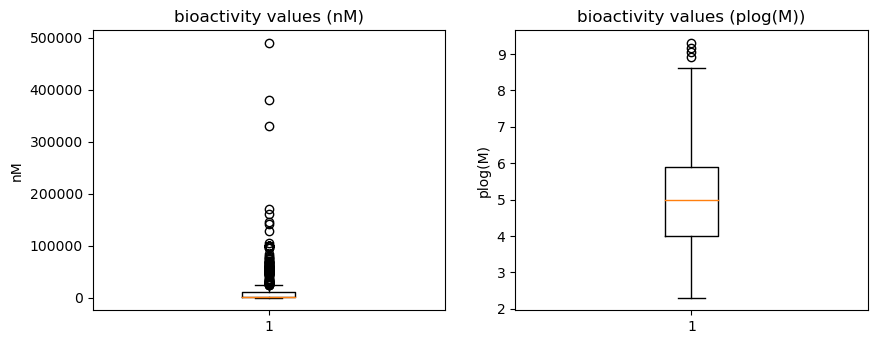

In [279]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.title("bioactivity values (nM)")
plt.ylabel("nM")
plt.boxplot(cftr_all["Bioactivity Value (nM)"])

#ec50["Bioactivity Value (nM)" ].describe()

plt.subplot(2,2,2)
plt.title("bioactivity values (plog(M))")
plt.ylabel("plog(M)")
plt.boxplot(cftr_all["p_log_values (M)" ])


# 3) Model 1 --> ANN

Goal of this model is to use an ANN to machine learn the fingerprint data of the ligands and predict the pBindingAffinities values

## ANN: Normalize Data 

Features --> Fingerprint 

Value to predict --> pBindingAffinitiies(pIC50 or pEC50)

In [281]:
# Features will be fingerprint at 1024 and 2 radius 
X = np.array(list(cftr_all['Fingerprint']))

# Value we hope to predict plog Bioactivity values 
y = cftr_all["p_log_values (M)"].values 

scaler = StandardScaler()
X = scaler.fit_transform(X)


## ANN : functions/classes used in this model 

ANN Model Class: 
    
- ANN_paper 
    - Source: Jiaying You, Robert D. McLeod, Pingzhao Hu, Predicting drug-target interaction network using deep learning model, Computational Biology and Chemistry, Volume 80, 2019, Pages 90-101,ISSN 1476-9271,https://doi.org/10.1016/j.compbiolchem.2019.03.016.

Functions/Classes to train model: 

- Trainer --> class to train the ANN_paper, evaluates performance and makes predictions based on the model. 
    - Source: Chem 277 Hw # 7 
- K-fold --> for K-fold cross validation to assess model performance and generalization capability. 
    - Source: Chem 277 Hw # 7 

Model Evaluation functions: 

- Show_correlation --> compares actual vs predicted values and the correlation coefficient. 
    - Source: Chem 277 Hw # 4  
- prediction_accuracy --> shows the % of predictions that are in a certain tolerance range
- coefficient_of_determination --> find multiple R^2 to show the proportion of variance in the observations the model explains 
- compare_baseline --> shows the mse/rmse reductions between baseline predictions and predictions 

In [322]:
class ANN_paper(nn.Module): 
    """
    ANN_paper: 
    - adapted ANN model with 3 fully conncted layers with dropout and tanh, sigmoid activation functions. 
    """
    def __init__(self, input_size):
        """
        initilize the ANN_paper object 
        Inputs: 
            - input_size (int): sizes of the input array 
                - for this project : 1024 (fingerprint vector length)
        Outputs: 
            - none, initilized ANN_paper object 
        """
        super(ANN_paper, self).__init__()
        
        # define layers in ANN 
        self.fc1 = nn.Linear(input_size, 128)           
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)           
        
        # define Dropout layer 
        self.dropout = nn.Dropout(0.15)   

    def forward(self, x):
        """
        Function : foward --> define the forward pass of the neural netowrk 

        Inputs: 
            - x : (tensor) input data to the ANN. (should be compatible with input_size) 
        Outputs: 
            - x : (tensor) output of the input data after a foward pass in the ANN
        """
        # tanh activation function
        x = torch.tanh(self.fc1(x))
        # dropout layer
        x = self.dropout(x)   
        # sigmoid activation function     
        x = torch.sigmoid(self.fc2(x))  
        # dropout layer 
        x = self.dropout(x)       
        x = self.fc3(x)           
        return x

### ANN functions/classes : Trainer Class 
- Trainer Class will 
    - initialize the model (__init___)
    - train the model on the given data set (train)
    - evaluate the model based on MSE/RMSE loss functions (evaluate)
    - predict the outputs based on given inputs and trained model (prediction)

Since this is a regression task, 
- Loss function : Mean Squared Error (MSE) 
- "Accuracy" function : Root Mean Sqaured Error (RMSE) (sqrt of mse)

In [308]:
# Model Trainer 
# Loss function --> MSELoss()
class Trainer():
    """
    TRAINER CLASS: train the ANN 
    """
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: torch.tensor(x, dtype=torch.float)):
        """
        Function __init__: Initialization 
        Inputs: 
            - model: (obj)  Neural Network Class 
                - used in my model: ANN_model
            - optimizer_type: (str) ADAM or SGD 
                - used in my model: ADAM
            - learning_rate: (float) learning rate of optimizer 
                - used in my model: 1e-5
            - epochs:(int) number of training epochs (passes through training dataset) 
                - used in my model: 500
            - batch_size: (int) size of batches which will be split during training 
                - used in my model: 100
            - input_transform: transform to input data 
                - default: pytorch tensor of floats 
        Outputs: 
            - none. Initializers the attributes of the trainer class 

        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate, momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), lr=learning_rate)
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform
        self.loss_fn = nn.MSELoss()  # Loss function for regression
        self.train_losses = []
        self.val_losses = []
        self.error=[]
        self.val_error=[]

    def train(self, inputs, outputs, val_inputs, val_outputs, early_stop=False, l2=False, silent=False):
        """
        Function train --> trains model 
        Inputs: 
            - inputs : (numpy array) input data for training 
            - outputs : (numpy array) target outputs for the training data 
            - val_inputs : (numpy array) input data for validation set 
            - val_outputs : (numpy array) target output for validation set 
            - early_stop : (Boolean) use early stop to halt training when validation loss stops 
            - l2: (Boolean) use L2 regularization to prevent overfitting 
            - silent (Boolean): controls for verbose print statements during training 
        Outputs: 
            - dictionary containing: 
                - losses: training losses for each epoch 
                - error: rmse for the training data for each epoch 
                - val_losses: validation losses for each epoch 
                - val_error: rmse of the validation data for each epoch
        """
        
        inputs = self.input_transform(inputs)
        outputs = torch.tensor(outputs, dtype=torch.float)
        val_inputs = self.input_transform(val_inputs)
        val_outputs = torch.tensor(val_outputs, dtype=torch.float)

        lowest_val_loss = float('inf')
        best_weights = None
        losses = []
        val_losses=[]
        error =[]
        val_error =[]

        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            total_loss = 0
            # train by batches 
            for i in range(0, len(inputs), self.batch_size):
                batch_input = inputs[i:i + self.batch_size]
                batch_output = outputs[i:i + self.batch_size]

                batch_predictions = self.model(batch_input)
                batch_predictions = torch.squeeze(batch_predictions)
                # nnMSE loss function 
                loss = self.loss_fn(batch_predictions, batch_output)
                
                #if l2 regularization
                if l2:
                    self.optimizer = Adam(self.model.parameters(), weight_decay=1e-5)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            # Validation
            val_loss = self.evaluate(val_inputs, val_outputs)
            if early_stop and val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_weights = self.model.state_dict()
            if not silent:
                print(f"Epoch {n_epoch + 1}/{self.epoch} - Loss: {total_loss:.3f}, Val Loss: {val_loss:.3f}")
            losses.append(total_loss)
            val_losses.append(val_loss)
            error.append(np.sqrt(total_loss))
            val_error.append(np.sqrt(val_loss))

        if early_stop:
            self.model.load_state_dict(best_weights)
        return {"losses": losses, "error": error, "val_losses":val_losses, "val_error": val_error}

    def evaluate(self, inputs, outputs):
        """
        Function: evaluate --> calculates loss of the model on the given data set/ evaluates the model 
        Inputs: 
            - inputs : (numpy array) input data for training 
            - outputs : (numpy array) target outputs for the training data 
        Outputs: 
            - loss.item() : (float) representing the MSE of the provided data set. 

        """
        self.model.eval()
        inputs = self.input_transform(inputs)
        outputs = torch.tensor(outputs, dtype=torch.float)
        with torch.no_grad():
            predictions = self.model(inputs)
            predictions = torch.squeeze(predictions)
            loss = self.loss_fn(predictions, outputs)
        return loss.item()
    
    def predict(self, inputs): 
        """
        Function: predict --> uses trained model to make predictions on new data. 
        Inputs: 
            - inputs : (numpy array) input data for training
        Outputs: 
            - predictions: (numpy array) predicted outputs of the given input data based on trained model.
        """
        self.model.eval()
        inputs = self.input_transform(inputs)
        with torch.no_grad():
            predictions = self.model(inputs)
            predictions = torch.squeeze(predictions)
        return predictions


In [624]:
def Kfold(model_func,k,Xs,ys,test_Xs,test_ys,epochs,draw_curve=True,early_stop=False,batchsize=100, optimizer='adam',lr=1e-5,l2=True, input_shape=(-1,1024)):
    """
    Function Kfold --> perform 5-fold cross validation on a given dataset using the ANN model. 

    Inputs: 
        - model_func : input model function (ann class)
            - used in my model: this is essentially a placeholder so that I know what model I'm running but it is hard coded in this.  
        - k : (int) Number of folds 
            - used in my model: 5
        - Xs : (numpy array) the input training data set 
        - ys : (numpy array) the output training data set corresponding to Xs
        - test_Xs : (numpy array) the input test data set 
        - test_ys : (numpy array) the output test data set corresponding to test_ys
        - epochs:(int) number of training epochs (passes through training dataset) 
            - used in my model: 500
        - draw_curve : (boolean) controls of printing loss and error curves 
        - early_stop : (Boolean) use early stop to halt training when validation loss stops
        - batch_size: (int) size of batches which will be split during training  
            - used in my model : 100 
        - optimizer_type: (str) ADAM or SGD 
            - used in my model: ADAM 
        - lr: (float) learning rate of optimizer 
            - used in my model: 1e-5
        - l2: (Boolean) use L2 regularization to prevent overfitting
        - input_shape:(tuple) information about the shape of the inputs. 
    Outputs: 
        - None, prints loss and error values to console and prints graph of loss and erorrs.
        
    """
    # The total number of examples for training the network
    total_num=len(Xs)
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # lists to store training and test errors 
    train_err_all=[]
    test_err_all=[]
    val_err_all=[]
    fold=0
    # split int train and validation sets 
    for train_selector,val_selector in kf.split(range(total_num)):
        fold+=1
        print(f'Fold #{fold}')
        train_Xs=Xs[train_selector]
        val_Xs=Xs[val_selector]
        train_ys=ys[train_selector]
        val_ys=ys[val_selector]
        
        # Reintialize model and weights 
        # no need to accept multiple model arguments, only one is involved for this project. 
        # Hence, I hard coded this 
        model=ANN_paper(1024)
        # run trainer 
        trainer = Trainer(model, optimizer_type="adam", learning_rate=lr, epoch=epochs, batch_size=batchsize)
        # save output dictionary of trainer 
        log = trainer.train(train_Xs, train_ys , val_Xs, val_ys,l2=l2, silent=True) 
        # prints the loss and error curves based on log dictionary
        if draw_curve:
            plt.figure()
            plt.plot(log["losses"], label="losses")
            plt.plot(log["val_losses"], label="validation_losses")
            plt.legend()
            plt.title(f'Fold #{fold} loss - MSE')
            plt.figure()
            plt.plot(log["error"], label="error")
            plt.plot(log["val_error"], label="validation_error")
            plt.legend()
            plt.title(f'Fold #{fold} accuracy - RMSE')
        # if early stop 
        if early_stop:
            report_idx= np.argmin(log["val_losses"])
        else:
            report_idx=-1
        # print the errors for this fold 
        test_err=np.sqrt(trainer.evaluate(test_Xs,test_ys))
        val_err_all.append(log["val_error"][report_idx])
        train_err_all.append(log["error"][report_idx])
        test_err_all.append(test_err)
        print("Train error:",log["error"][report_idx])
        print("Validation error:",log["val_error"][report_idx])
        print("Test error:",test_err)
        print("\n")
    # print the loss average of the 5 folds 
    print("\nFinal results:")
    print("Training RMSE :%f+-%f"%(np.average(train_err_all),np.std(train_err_all)))
    print("Validation RMSE :%f+-%f"%(np.average(val_err_all),np.std(val_err_all)))
    print("Testing RMSE:%f+-%f"%(np.average(test_err_all),np.std(test_err_all)))

In [351]:
# Performce Metrics Functions 
def show_correlation(xs,ys):
    """
    Function: Show correlation --> prints a prediction vs actual graph and shows correlation coefficient. 
    Inputs:
        - xs : (numpy array) input Xs 
        - ys : (numpy array) output ys corresponding t xs
    Outputs: 
        - prints the correlation coefficient and graphs 
    """
    plt.figure()
    plt.scatter(xs,ys,s=10)

    # Add line of best fit 
    m,b = np.polyfit(xs,ys,1)
    plt.plot(xs, m*xs+b, color="red")

    plt.xlabel("Predictions")
    plt.ylabel("Ground truth")

    # Calc correlation coefficient 
    corr=np.corrcoef([xs,ys])[1,0]
    print("Correlation coefficient:",corr)

def prediction_accuracy(predict, actual, tol): 
    """
    Function: prediction_accuracy --> finds the % of predictions that are in a certain tolerance range of actual 

    Inputs:
        - predict: (numpy array) predicted values from model 
        - actual: (numpy array) actual values from dataset 
        - tol: (float) set a tolerance range (+/- percent) for which predicted values are different from the actual values. 
    Outputs: 
        - acc.item() : percent of predictions that fall in the tolerance range of their actual values. 

    """
    # absolute percent differences in predicted vs actual
    diff = torch.abs(predict-actual)/np.abs(actual)
    
    # if percent diff falls within the tolerance range 
    acc_pred = torch.sum(diff<=tol)

    # percent of predictions that are within the range
    acc = acc_pred.float()/len(predict)
    
    return 100*acc.item()

def coefficient_of_determination(input, predictions): 
    """
    Function: coefficient_of_determination --> finds the multiple r value for the predictions against the actual

    Inputs: 
        - input : (numpy array) the actual output values in the data set
        - predictions : (numpy array) the predicted output values based on learned model 

    Outputs: 
        - multiple r : the multiple r^2 of the model. 
                        the propoprtion of varaince in the observations the model explains. 
    """
    multiple_r = np.var(predictions)/np.var(input)

    print(f"Multiple R^2 of this model : {multiple_r}")

    return multiple_r

def compare_baseline(baseline, predictions, actual):
    """
    Function: compare_baseline --> see how the mse and rmse changes from a baseline value 

    Inputs: 
        - baseline : (numpy array) baseline output values determined for this data set 
        - predictions : (numpy array) prediction output values from model 
        - actual : (numpy array) actual output from data set
    Outputs: 
        - mse_diff : (float) percent decrese of mse value of predicitons from baseline 
        - rmse_diff : (float) percent decrese of rmse value of predicitons from baseline 
    """ 
    mse_bl = mean_squared_error(actual, baseline)
    mse_pr = mean_squared_error(actual, predictions)
    mse_diff = ((mse_bl -mse_pr)/ mse_bl) *100 
    rmse_diff = ((np.sqrt(mse_bl) -np.sqrt(mse_pr))/ np.sqrt(mse_bl)) *100 

    print(f"{mse_diff} % in reduction of model predictions MSE to baseline MSE")
    print(f"{rmse_diff} % in reduction of model predictions RMSE to baseline RMSE")

    return mse_diff, rmse_diff


### ANN functions/classes: parameter optimization/Selection

In my Checkpoint 2, I showcased rigorous testing of parameters optimization.
I have decided to leave those out for the sake of brevity.

- I saved the values of the error and loss in a google doc. 

Paramaters decided on: 

- ANN --> the one from the paper 
- Fingerprinting ---> n_bits = 1024, radius = 3
- Trainer parameters --> learning rate = 1e-5, epochs = 500, batch size = 100
- During Training --> L2 Regularization and Adam Optimizer

Since it is a regression task: 

- Loss function : Mean Square Error (MSE)
- Accuracy function : Root Mean Sqaure Error (RMSE)

## ANN: Run Model 

- 5-fold cross validation 
- evaluate performance

Loss/ accuracies of the train,val and test sets are all printed below. This also includes the loss/accuracy graphs.

Final average results from the 5-fold cross validation: 

- Training RMSE :0.866309+-0.026476
- Validation RMSE :0.832709+-0.050157
- Testing RMSE:0.879873+-0.020955

They all seem very close to each other and to 0. I believe that this is a indication that my model a good representation of the molecular fingerprints. 
I initially had some issues with overfitting but looking at the validation vs training data, there doesn't much deviation and the validation curves seem to match the training curves below. The test data also resulted in a small average loss, another indication that my model should be a good representation of the given data. 

Fold #1


  0%|          | 0/500 [00:00<?, ?it/s]

Train error: 0.8650178100083717
Validation error: 0.817223062707881
Test error: 0.8471170987293645


Fold #2


Train error: 0.8208553879255179
Validation error: 0.8848292515257513
Test error: 0.8860877056046841


Fold #3


Train error: 0.9030839765530634
Validation error: 0.8147885663227064
Test error: 0.9124739773841382


Fold #4


Train error: 0.8754793284735529
Validation error: 0.8909009873940831
Test error: 0.8756421321524358


Fold #5


Train error: 0.8671106871531321
Validation error: 0.7558009792904996
Test error: 0.8780427887467895



Final results:
Training RMSE :0.866309+-0.026476
Validation RMSE :0.832709+-0.050157
Testing RMSE:0.879873+-0.020955


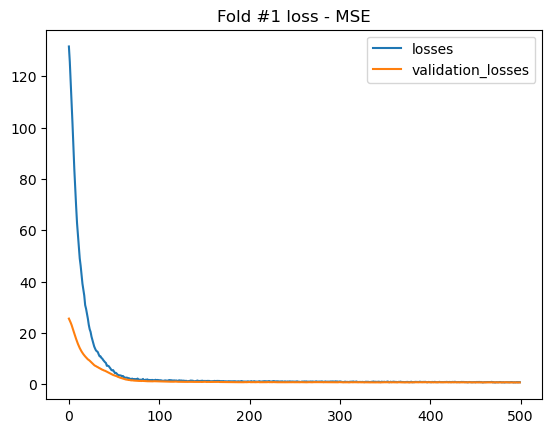

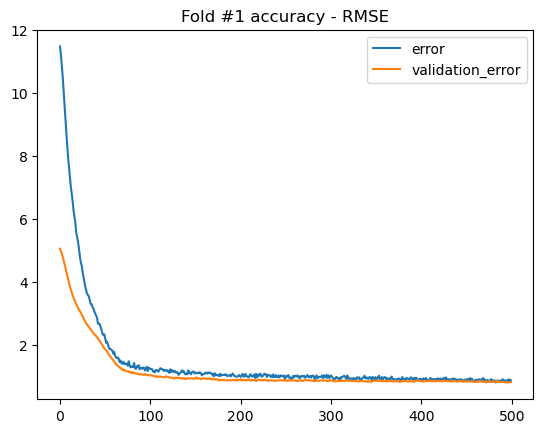

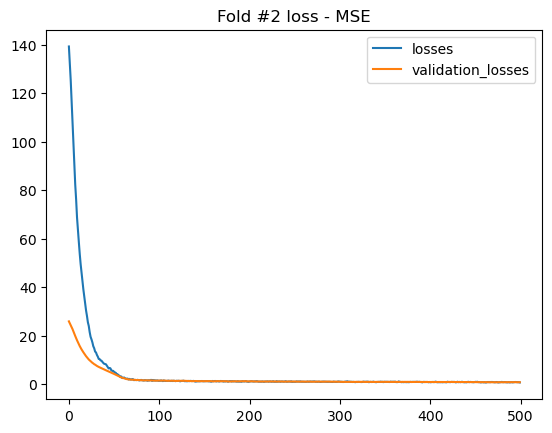

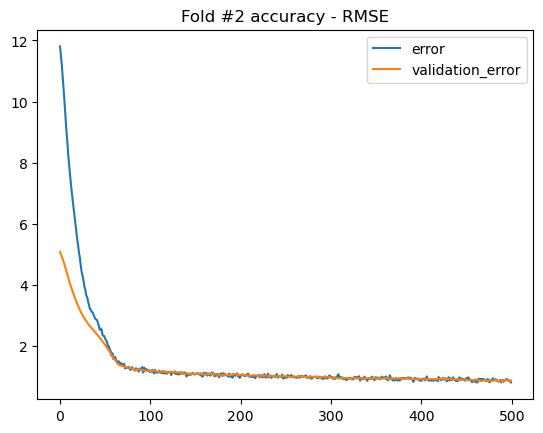

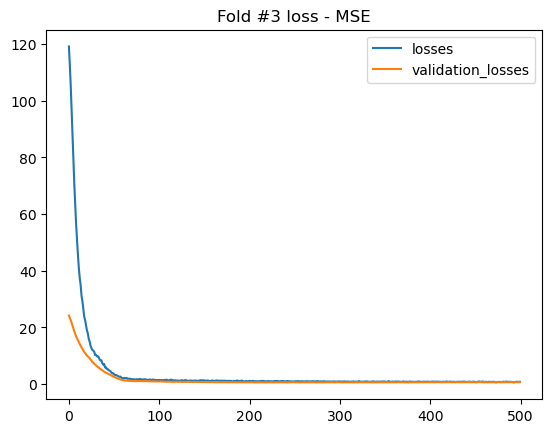

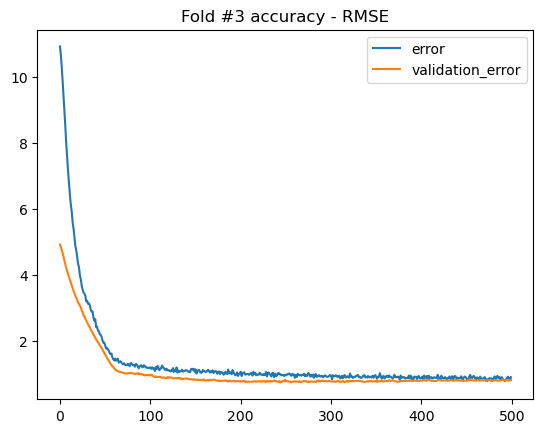

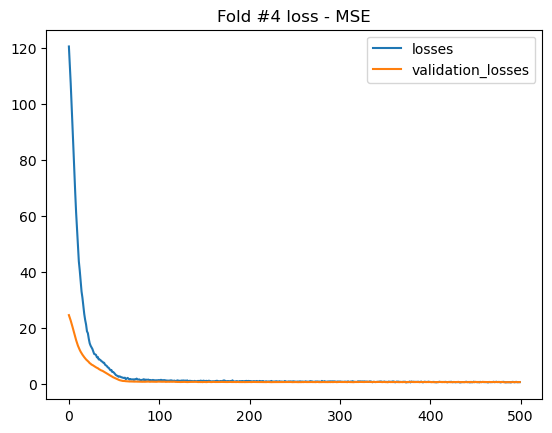

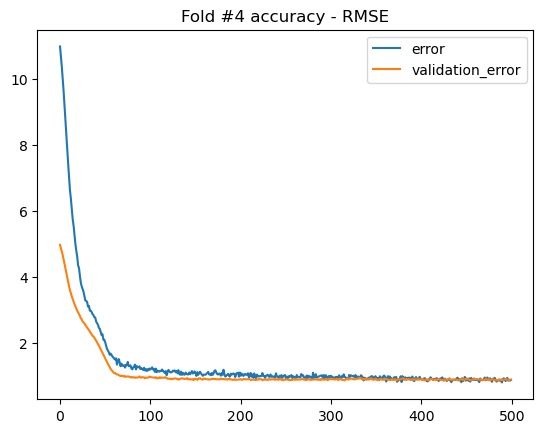

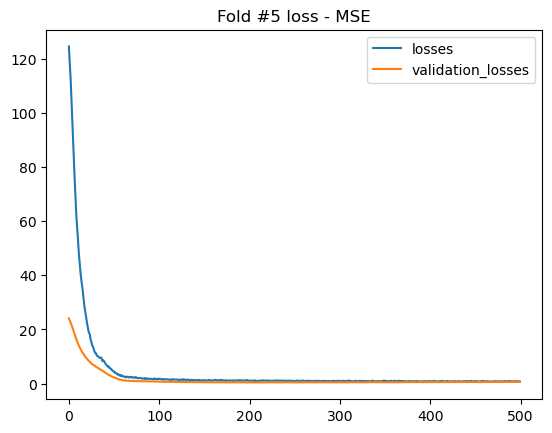

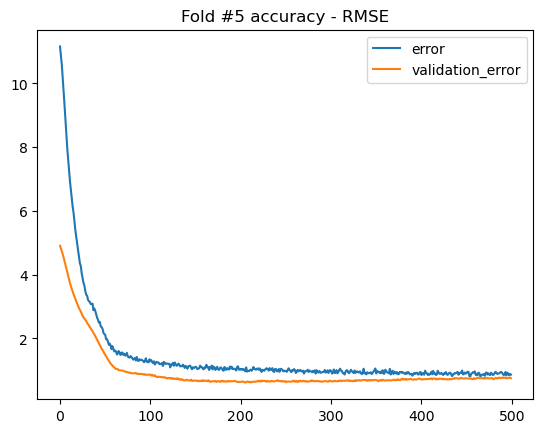

In [625]:
# Features will be fingerprint at 1024 and 2 radius 
X = np.array(list(cftr_all['Fingerprint']))

# Value we hope to predict plog Bioactivity values 
y = cftr_all["p_log_values (M)"].values 

# Normalize data 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Set model as ANN_paper with starting size of 1024. 
model = ANN_paper(1024)

# split the data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Run 5-fold cross validation 
Kfold(model,5,X_train,y_train,X_test,y_test,epochs=500,draw_curve=True,early_stop=False,batchsize=100,optimizer='adam',lr=1e-5,l2=True)


## ANN : Model Evalutation 

Look at ANN Performance metrics!! 
- RMSE, MSE, Correlation Coeffients 
- Baselime Comparisons 
- R^2 value 
- within range

In [324]:
# One run of the Model --> use to evaluate 
model = ANN_paper(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
trainer_ann= Trainer(model, optimizer_type="adam", learning_rate=1e-5, epoch=500, batch_size=100)
trained_ann = trainer_ann.train(X_train, y_train , X_test, y_test,l2=True, silent=True)

### ANN Metrics - RMSE/MSE/ Correlation Coefficients

TRAIN DATA: 
- Correlation Coefficient : 0.9931957189060892
- Train MSE: 0.024951178580522537
- Train RMSE: 0.1579594206767122

Notes: Very strong correlation coefficient to actual y values, very small MSE and RMSE values. Training on Training set seems successful. The low RMSE value indcates that there is a lower average loss across the dataset, hence a more "accurate" prediction. 

TEST DATA: 
- Correlation Coefficient : 0.7856436954267767
- Test MSE: 0.6917089819908142
- Test RMSE: 0.8316904363949451

Notes: Still a farily strong correlation coefficient to actual y values. Larger MSE/RMSE values compared to train data as expected but still quite small. The ANN model is able to make fairly good predictions from the test set. 

Residuals of test data : 

- no clear directional patterns, points seem to be randomly scattered about the y=0 line. 
- Model is not biased to stronger/weaker binders. 

Train MSE: 0.024951178580522537
Train RMSE: 0.1579594206767122

training set
Correlation coefficient: 0.9931957189060892

Test MSE: 0.6917089819908142
Test RMSE: 0.8316904363949451

test set
Correlation coefficient: 0.7856436954267767


Text(0, 0.5, 'Residuals')

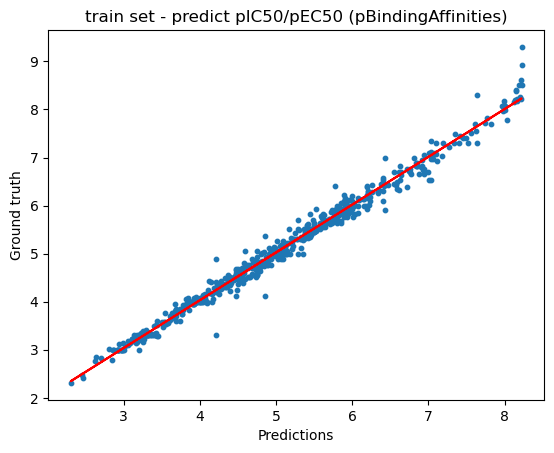

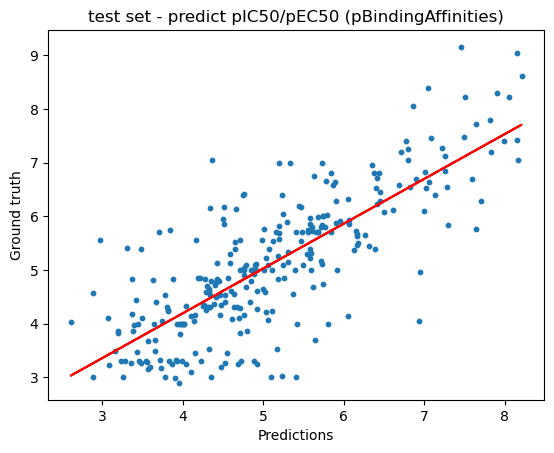

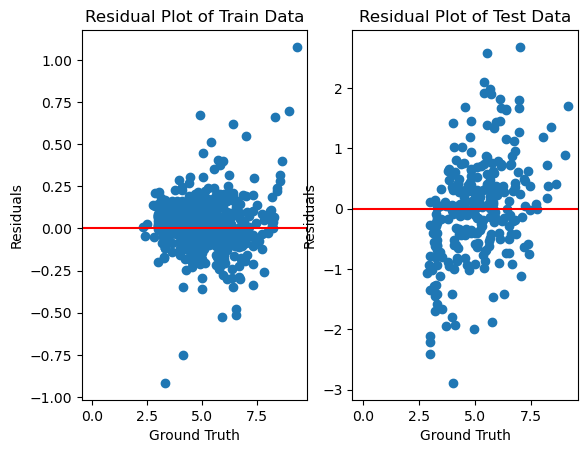

In [367]:
# Performance metrics --> RMSE/MSE 

# Find MSE and RMSE of train set 
loss= trainer_ann.evaluate(X_train, y_train)
print(f'Train MSE: {loss}')
rmse = math.sqrt(loss)
print(f'Train RMSE: {rmse}')

# Find the predictions of the Train set and use the show_correlation function 
predictions_train = trainer_ann.predict(X_train)
print("\ntraining set")
show_correlation(predictions_train, y_train)
plt.title("train set - predict pIC50/pEC50 (pBindingAffinities)")

# Find MSE and RMSE of test set 
test_loss= trainer_ann.evaluate(X_test, y_test)
print(f'\nTest MSE: {test_loss}')
test_rmse = math.sqrt(test_loss)
print(f'Test RMSE: {test_rmse}')

# Find the predictions of the Test set and use the show_correlation function 
predictions_test = trainer_ann.predict(X_test)
print("\ntest set")
show_correlation(predictions_test, y_test)
plt.title("test set - predict pIC50/pEC50 (pBindingAffinities)")

plt.figure()
plt.subplot(1,2,1)
# residual plot to see if my model has any specific biases 
residuals_train = y_train - np.asanyarray(predictions_train)
plt.scatter( y_train, residuals_train) 
plt.axline((0,0), slope=0, color='red')
plt.title("Residual Plot of Train Data")
plt.xlabel("Ground Truth")
plt.ylabel("Residuals")

plt.subplot(1,2,2)
# residual plot to see if my model has any specific biases 
residuals_test = y_test - np.asanyarray(predictions_test)
plt.scatter( y_test, residuals_test) 
plt.axline((0,0), slope=0, color='red')
plt.title("Residual Plot of Test Data")
plt.xlabel("Ground Truth")
plt.ylabel("Residuals")


### ANN Metrics: Baseline Comparisons 

Baseline Predictions: Use the average pBindingAffinities for all compounds in the given dataset 
- easiest model to create is if all predictions were the average of the values. 
- showcases the improvements of my model over a straight forward, simple predictive model

Test Set:
- 59.31464883469258 % in reduction of model predictions MSE to baseline MSE
- 36.21493030080831 % in reduction of model predictions RMSE to baseline RMSE

Notes: Was able to reduce the MSE/RMSE values significantly compared to the baseline predictions. 
- My ANN model is more effective than a baseline model. 

Train Set: 
- 98.60393669749878 % in reduction of model predictions MSE to baseline MSE
- 88.18448772798565 % in reduction of model predictions RMSE to baseline RMSE

Since RMSE is a relative value, I wanted to give some mearning to it. The baseline model comparisons showcases that my ANN model has predictive value and is able to predict binding affinity values more accurately than just taking the average of the test or train sets. 

In [345]:
# Save the Predictions of both sets 
predictions_test = trainer_ann.predict(X_test)
predictions_train = trainer_ann.predict(X_train)

# Find BASELINE MERICS OF TEST SET 
baseline_test = [np.mean(y_test)]*len(y_test)
bl_mse=mean_squared_error(baseline_test, y_test)
print("baseline stats:")
print(f'Test MSE: {bl_mse}')
bl_rmse = math.sqrt(bl_mse)
print(f'Test RMSE: {bl_rmse}')
compare_baseline(baseline_test, predictions_test, y_test)

# Find BASELINE MERICS OF TRAIN SET 
baseline_train = [np.mean(y_train)]*len(y_train)
bl_mse_train=mean_squared_error(baseline_train, y_train)
print("\nbaseline stats:")
print(f'Train MSE: {bl_mse_train}')
bl_rmse_train = math.sqrt(bl_mse_train)
print(f'Train RMSE: {bl_rmse_train}')


compare_baseline(baseline_train, predictions_train, y_train)



baseline stats:
Test MSE: 1.7001425237669303
Test RMSE: 1.3038951352646924
59.31464883469258 % in reduction of model predictions MSE to baseline MSE
36.21493030080831 % in reduction of model predictions RMSE to baseline RMSE

baseline stats:
Train MSE: 1.787252558769497
Train RMSE: 1.336881654735937
98.60393669749878 % in reduction of model predictions MSE to baseline MSE
88.18448772798565 % in reduction of model predictions RMSE to baseline RMSE


(98.60393669749878, 88.18448772798565)

### ANN Metrics : R squared or Coefficient of determination 

Test Set --> Multiple R^2 : 0.8849965768226823

Train Set --> Multiple R^2 : 0.9984418197572146

The proportion of variance in the observations my ANN model explains is very close to 1 for both data sets. It showcases that the target variable (molecular fingerpints) has a strong association to the feature varaible. 


In [390]:
predictions_test = trainer_ann.predict(X_test)
print("Test Set")
coefficient_of_determination(y_test,np.asanyarray(predictions_test ))

predictions_train = trainer_ann.predict(X_train)
print("Train Set")
coefficient_of_determination(y_train,np.asanyarray(predictions_train ))

Test Set
Multiple R^2 of this model : 0.8849965768226823
Train Set
Multiple R^2 of this model : 0.9984418197572146


0.9984418197572146

### ANN Metrics --> Accurracy within tolerance range 

- How good is my predictions? Using tolerance range % 
- Setting different "tolerance ranges" or the (actual_BindingAffinity +/- x%) to see how many of my predictions fall in that window. 
- around 80% of my predictions fall in +/- 20% range of the actual values. 
- whereas 1/3 of the predictions fall in the +/- 5% of the actual value. 

Percent of predicted pIC/pEC values within 1% of actual value: 10.139860212802887%
Percent of predicted pIC/pEC values within 5% of actual value: 33.916082978248596%
Percent of predicted pIC/pEC values within 10% of actual value: 55.59440851211548%
Percent of predicted pIC/pEC values within 20% of actual value: 79.72028255462646%


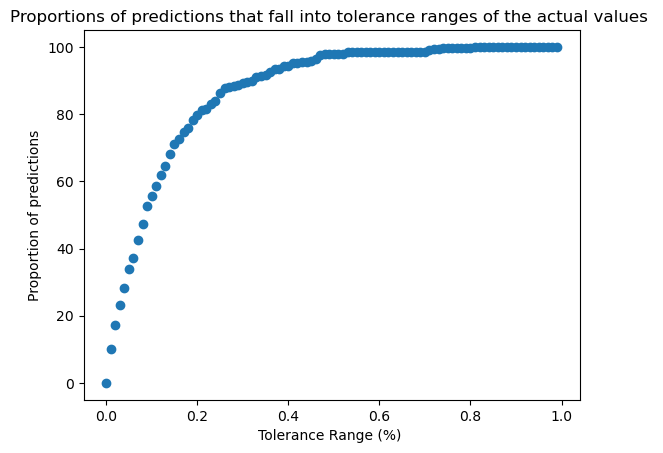

In [386]:
predictions = trainer_ann.predict(X_test)

acc = [prediction_accuracy(predictions, y_test, x) for x in np.arange(0,1,0.01)]

plt.scatter(x=np.arange(0,1,0.01), y=acc)
plt.ylabel("Proportion of predictions")
plt.xlabel("Tolerance Range (%) ")
plt.title("Proportions of predictions that fall into tolerance ranges of the actual values ")


one_percent = prediction_accuracy(predictions, y_test, 0.01)
five_percent = prediction_accuracy(predictions, y_test, 0.05)
ten_percent = prediction_accuracy(predictions, y_test, 0.10)
twenty_percent = prediction_accuracy(predictions, y_test, 0.2)
print(f"Percent of predicted pIC/pEC values within 1% of actual value: {one_percent}%")
print(f"Percent of predicted pIC/pEC values within 5% of actual value: {five_percent}%")
print(f"Percent of predicted pIC/pEC values within 10% of actual value: {ten_percent}%")
print(f"Percent of predicted pIC/pEC values within 20% of actual value: {twenty_percent}%")


# 4)  Model 2 : Random Forest 

Goal of this model is to use Random Forest Regression to learn the fingerprint data of the ligands and predict the pBindingAffinities values

Sources: 
- https://towardsdatascience.com/random-forest-regression-5f605132d19d 
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [392]:
# Will be using the same features. 
# Features will be fingerprint at 1024 and 2 radius 
X = np.array(list(cftr_all['Fingerprint']))

# Value we hope to predict plog Bioactivity values 
y = cftr_all["p_log_values (M)"].values 

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#ensure that X has not been changed, should be 865.
len(X)

865

## RF: Optimize Parameters --> Using GridSearchCV to find best parameters 

- Best parameters:

max_depth = 50, n_est = 512, max_features = 'sqrt'

In [650]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [64, 128, 512, 1024], 
          'max_depth': [10, 30, 50], 
          'max_features' : ['sqrt', 1, 5, None]
          }
model = RandomForestRegressor()

grid = GridSearchCV(model, params, cv=5)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

Best parameters: {'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 512}


## RF: Optimize Parameters --> Compare MSE, RMSE of test_set for 4 different models 

1) RF with the best params from GridSearch
2) RF with smaller n_est for time-saving purposes 
3) Gradient Boosting Regressor (simple to implement, so thought I test it out. )
4) Baseline for RandomForest, if there is no model to train,

Baseline Conception 
- If there is no model, we can assume that the best predictor would be the mean Ec/Ic 50 values of the training set.
- Use those as the predicted_y values and calculate the mse/rmse with the test set y values. 
- This is the "baseline" if there is no model 

(Source --> Data 100 @ CaL )


Similarly, I will use:

Loss function: MSE, Accuracy function: RMSE

From the gridsearch graph, it seems like the RF with best parameters result in the lowest loss function. I will proceed with that model. 
There seems to be a slight increase in mse/rmse values for the "smaller n_est" version, so i will use the paramters found from GridSearchCV. 


RF_opt:
0.5117092831597813 0.7153385793872586
RF_smaller:
0.5165792591854277 0.718734484483267
Boost Baseline
0.6132678718137502 0.7831142137732849
Baseline
1.7083255020487977 1.307029265949618


Text(0, 0.5, 'Errors')

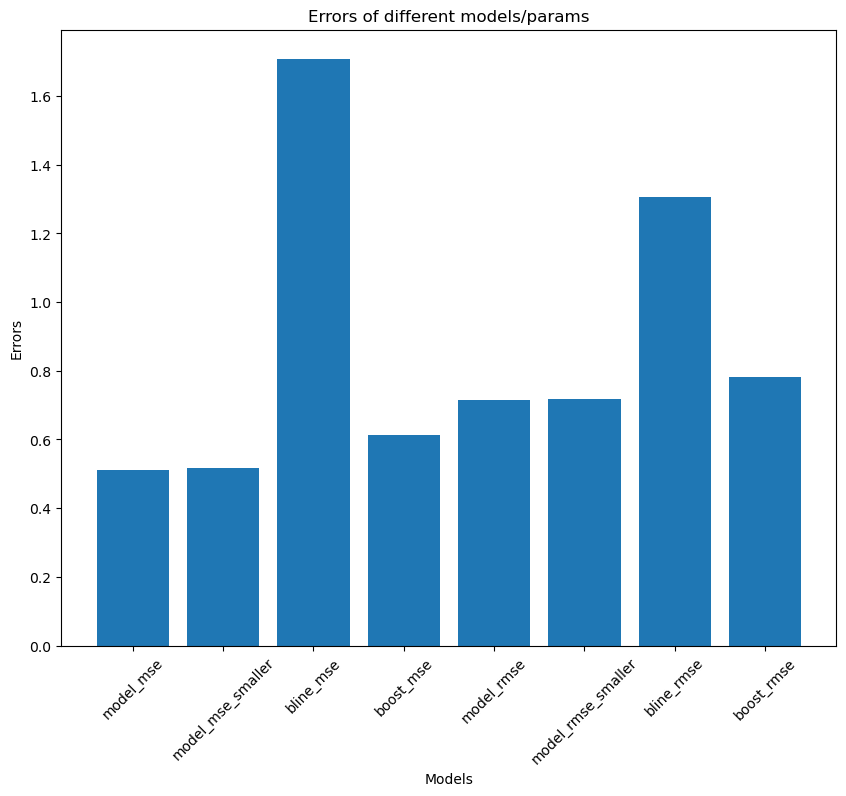

In [651]:
#1) RF with best params:
# Results from grid search to optimize randomforestregressor 
# max_depth =30, n_est = 1024
model = RandomForestRegressor(n_estimators = 512, max_depth=50, max_features ='sqrt', random_state=42)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
print("RF_opt:")
print(mse, rmse)


#2) RF with smaller n_est for time saving purposes 
model = RandomForestRegressor(n_estimators = 128, max_depth = 50, max_features ='sqrt', random_state=42)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
mse_opt = mean_squared_error(y_test, y_test_pred)
rmse_opt = np.sqrt(mse_opt)

print("RF_smaller:")
print(mse_opt, rmse_opt)

# 3) Gradient Boosting Regressor 
model_boost = GradientBoostingRegressor(random_state=42)
model_boost.fit(X_train, y_train)

boost_preds = model_boost.predict(X_test)
boost_mse = mean_squared_error(y_test, boost_preds)
boost_rmse = np.sqrt(boost_mse)

print("Boost Baseline")
print(boost_mse, boost_rmse)

# 4) baseline metric for the random forest 
# if no training, no model 
bl_y_train = np.mean(y_train)
bl_preds = np.full(shape=y_test.shape, fill_value=bl_y_train)

bl_mse = mean_squared_error(y_test,bl_preds)
bl_rmse = np.sqrt(bl_mse)

print("Baseline")
print(bl_mse, bl_rmse)
plt.figure(figsize=(10,8))
mse_data ={ 'model_mse': mse, 'model_mse_smaller': mse_opt,'bline_mse': bl_mse, 'boost_mse': boost_mse, 
           'model_rmse': rmse,'model_rmse_smaller': rmse_opt, 'bline_rmse': bl_rmse,'boost_rmse': boost_rmse
           }
name = list(mse_data.keys())
values = list(mse_data.values())
plt.bar(name, values)
plt.title("Errors of different models/params")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.ylabel("Errors")


## RF functions/classes: 

- I will use the RandomForestRegressor from sklearn.ensemble to run this model 
- Implemeted a Kfold_RF that will perform cross validatation the data with the Random Forest Model 

In [656]:
def Kfold_RF(k,Xs,ys,test_Xs,test_ys):
    """
    Function Kfold_RF --> perform 5-fold cross validation on a given dataset using the Random Forest model

    Inputs: 
        - k : (int) Number of folds 
            - used in my model: 5
        - Xs : (numpy array) the input training data set 
        - ys : (numpy array) the output training data set corresponding to Xs
        - test_Xs : (numpy array) the input test data set 
        - test_ys : (numpy array) the output test data set corresponding to test_ys
        - draw_curve : (boolean) controls of printing loss and error curves 
    Outputs: 
        - None, prints loss and error values to console and prints graph of loss and erorrs.
    """
    # The total number of examples for training the network
    total_num=len(Xs)
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # lists to store training and test errors (rmse) 
    train_err_all=[]
    test_err_all=[]
    val_err_all=[]
    # lists to store training and test loss (mse) 
    train_loss_all=[]
    test_loss_all=[]
    val_loss_all=[]
    fold=0
    # split int train and validation sets 
    for train_selector,val_selector in kf.split(range(total_num)):
        fold+=1
        print(f'Fold #{fold}')
        train_Xs=Xs[train_selector]
        val_Xs=Xs[val_selector]
        train_ys=ys[train_selector]
        val_ys=ys[val_selector]
        
        # Hard coded model (no need for others)
        model = RandomForestRegressor(n_estimators = 512, max_depth=50, max_features ='sqrt', random_state=42)
        # fit model to train data 
        model.fit(train_Xs, train_ys)
        
        # validation set errors (MSE)
        val_predictions = model.predict(val_Xs)
        val_loss = mean_squared_error(val_ys, val_predictions)
        val_err = np.sqrt(val_loss)
        val_err_all.append(val_err)
        val_loss_all.append(val_loss)
        
        # training set errors (MSE)
        train_predictions = model.predict(train_Xs)
        train_loss = mean_squared_error(train_ys, train_predictions)
        train_err = np.sqrt(train_loss)
        train_err_all.append(train_err)
        train_loss_all.append(train_loss)

        # test set errors (MSE)
        test_predictions = model.predict(test_Xs)
        test_loss = mean_squared_error(test_ys, test_predictions)
        test_err = np.sqrt(test_loss)
        test_err_all.append(test_err)
        test_loss_all.append(test_loss)

        # print the errors for this fold 
        print("Train loss:",train_loss)
        print("Validation loss:",val_loss)
        print("Test loss::",test_loss)
        print("\n")
        # print the r^2 value for each tree in the RandomForest.
        r2_all = []
        for tree in model.estimators_:
            r2 = tree.score(test_Xs, test_ys)
            r2_all.append(r2)
        plt.figure()
        plt.plot(range(1, len(r2_all) + 1), r2_all)
        plt.xlabel('Tree #')
        plt.ylabel('R^2 Value')
        plt.title('R^2 Values for Test set for each tree in RF ')
    # print the loss average of the 5 folds 
    print("Final results:")
    print("Training rmse :%f+-%f"%(np.average(train_err_all),np.std(train_err_all)))
    print("Testing rmse :%f+-%f"%(np.average(test_err_all),np.std(test_err_all)))
    print("Validation rmse :%f+-%f"%(np.average(val_err_all),np.std(val_err_all)))
    print("")
    print("Training mse :%f+-%f"%(np.average(train_loss_all),np.std(train_loss_all)))
    print("Testing mse :%f+-%f"%(np.average(test_loss_all),np.std(test_loss_all)))
    print("Validation mse :%f+-%f"%(np.average(val_loss_all),np.std(val_loss_all)))

## RF : Run Model 

- Use 5-fold cross validation on RF. 

Results: 

Final results:

RMSE
- Training rmse :0.285087+-0.009171
- Testing rmse :0.742417+-0.007157
- Validation rmse :0.741305+-0.062296

MSE
- Training mse :0.081359+-0.005223
- Testing mse :0.551235+-0.010654
- Validation mse :0.553414+-0.095649

There seems to be some slight overfitting in my model. The avg loss (mse) function of my training is much lower than my test/validation mse/rmse. However, the mse/rmse of the values are still fairly small.


Fold #1
Train loss: 0.0827999398737724
Validation loss: 0.501979372098858
Test loss:: 0.5372923136724377


Fold #2
Train loss: 0.07527553953548569
Validation loss: 0.5922405352511078
Test loss:: 0.5488447036358164


Fold #3
Train loss: 0.08836966345822377
Validation loss: 0.4750172920950227
Test loss:: 0.5694724864663655


Fold #4
Train loss: 0.08493543214292681
Validation loss: 0.47380888056734344
Test loss:: 0.5543418183246005


Fold #5
Train loss: 0.07541269073070249
Validation loss: 0.724024069663033
Test loss:: 0.5462215136260217


Final results:
Training rmse :0.285087+-0.009171
Testing rmse :0.742417+-0.007157
Validation rmse :0.741305+-0.062296

Training mse :0.081359+-0.005223
Testing mse :0.551235+-0.010654
Validation mse :0.553414+-0.095649


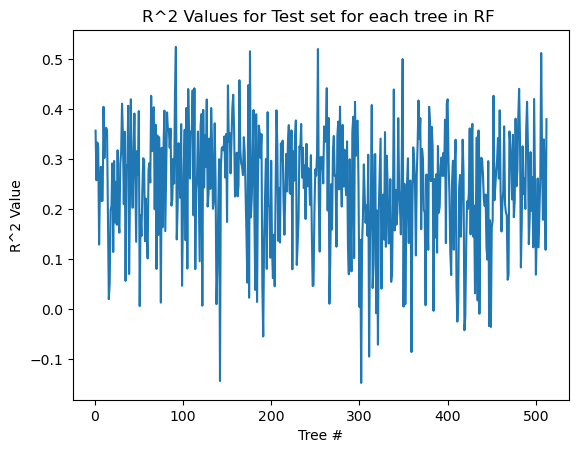

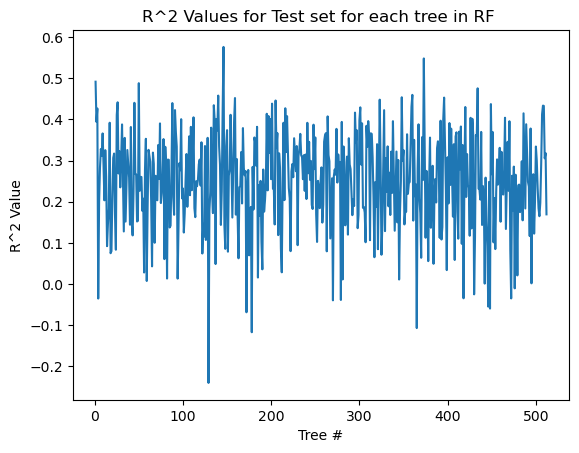

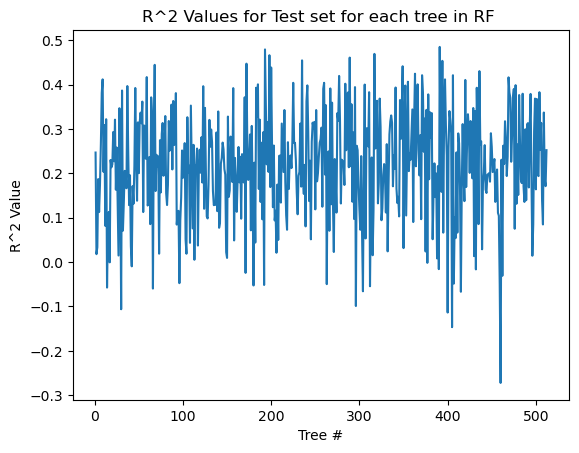

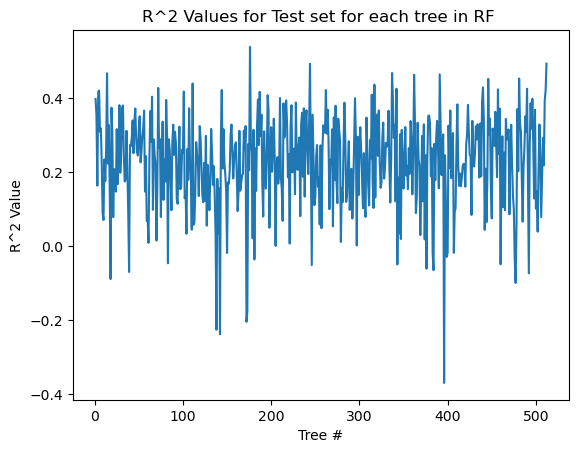

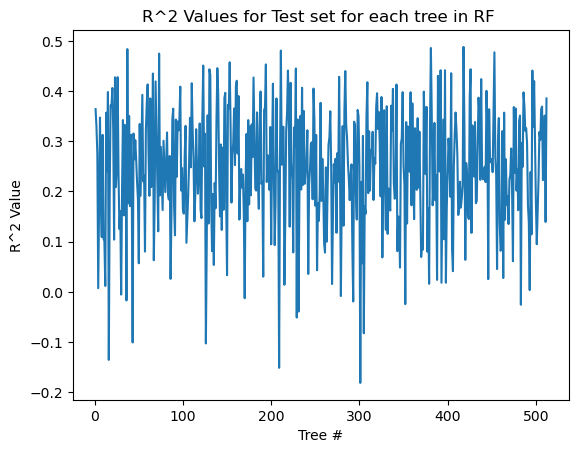

In [657]:
# Chosen Model 

# Features will be fingerprint at 1024 and 2 radius 
X = np.array(list(cftr_all['Fingerprint']))

# Value we hope to predict plog Bioactivity values 
y = cftr_all["p_log_values (M)"].values 

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Kfold_RF(5,X_train,y_train,X_test,y_test)

## RF: Model Evaluation 

### RF Metrics: MSE, RMSE, correlation coefficient and residual plot.  

test set:
- MSE: 0.4688257171065882, RMSE: 0.6847084906050079
- Correlation coefficient: 0.8559711142026489

train set:
- MSE: 0.07774193362747614, RMSE: 0.2788224051748283
- Correlation coefficient: 0.9824430909766463

Similar MSE and RMSE values that indicate that the modeling fit is adequate. 

However, the residual plot looks fairly random, but it seems have a slight positive correlation. Which implies that (actual>predict) so this model maybe under-predicting the values. 

In part virtual screens are meant to predict pIC/EC50 values, but it is CRUCIAL for it to show RELATIVELY higher pIC50/pEC50 values for good binders.  

test set:
MSE: 0.5117092831597813, RMSE: 0.7153385793872586
Correlation coefficient: 0.8436256123114426

train set:
MSE: 0.07387123641992932, RMSE: 0.2717926349626298
Correlation coefficient: 0.9852028910074258


Text(0, 0.5, 'Residuals')

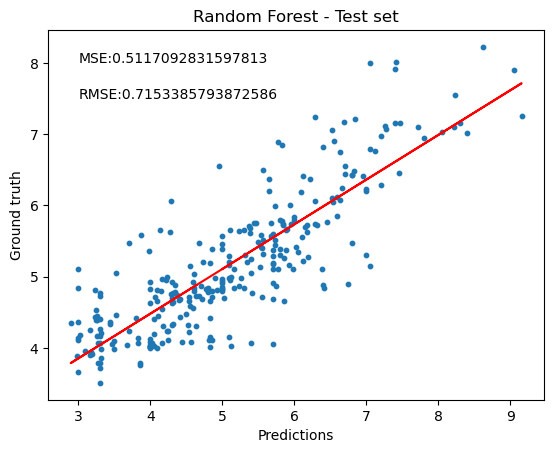

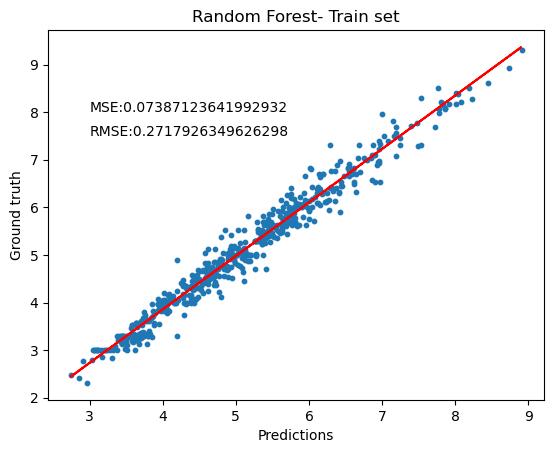

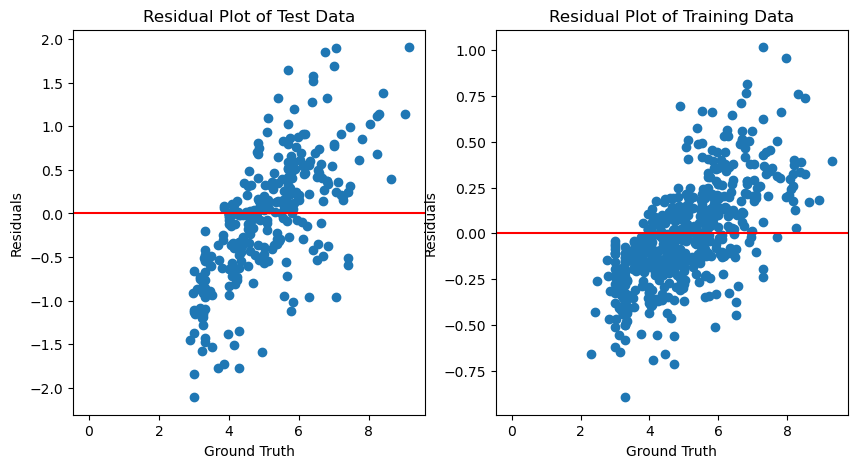

In [658]:
# Chosen Model 

# Features will be fingerprint at 1024 and 2 radius 
X = np.array(list(cftr_all['Fingerprint']))

# Value we hope to predict plog Bioactivity values 
y = cftr_all["p_log_values (M)"].values 

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestRegressor(n_estimators = 512, max_depth=50, max_features ='sqrt', random_state=42)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
print("test set:")
print(f"MSE: {mse}, RMSE: {rmse}")

show_correlation(y_test, y_test_pred)
plt.title("Random Forest - Test set")
plt.text(3,8,f"MSE:{mse}")
plt.text(3,7.5,f"RMSE:{rmse}")


y_train_pred = model.predict(X_train)
mse_tr= mean_squared_error(y_train, y_train_pred)
rmse_tr = np.sqrt(mse_tr)
print("\ntrain set:")
print(f"MSE: {mse_tr}, RMSE: {rmse_tr}")

show_correlation(y_train_pred, y_train )
plt.title("Random Forest- Train set")
plt.text(3,8,f"MSE:{mse_tr}")
plt.text(3,7.5,f"RMSE:{rmse_tr}")

# residual plot to see if my model has any specific biases
plt.figure(figsize=(10,5)) 
plt.subplot(1,2,1)
residuals_test = y_test - np.asanyarray(y_test_pred)
plt.scatter( y_test, residuals_test) 
plt.axline((0,0), slope=0, color='red')
plt.title("Residual Plot of Test Data")
plt.xlabel("Ground Truth")
plt.ylabel("Residuals")

plt.subplot(1,2,2)
residuals_train = y_train - np.asanyarray(y_train_pred)
plt.scatter( y_train, residuals_train) 
plt.axline((0,0), slope=0, color='red')
plt.title("Residual Plot of Training Data")
plt.xlabel("Ground Truth")
plt.ylabel("Residuals")

### RF Metrics : R^2 

- Test Set: Multiple R^2 of this model : 0.6063032201300366
- Train Set: Multiple R^2 of this model : 0.7919559588757464

The proportion of variance in the observations the model explains is very close to 1 for both data sets. 

In [659]:
y_test_pred = model.predict(X_test)
print("Test Set")
coefficient_of_determination(y_test,np.asanyarray(y_test_pred  ))

y_train_pred = model.predict(X_train)
print("Train Set")
coefficient_of_determination(y_train,np.asanyarray(y_train_pred  ))

Test Set
Multiple R^2 of this model : 0.5531008376300917
Train Set
Multiple R^2 of this model : 0.7683674382187254


0.7683674382187254

### RF Metrics : Baseline comparisons 

baseline stats for Train Data set:

- Train MSE: 1.787252558769497
- Train RMSE: 1.336881654735937
- 95.86677125974916 % in reduction of model predictions MSE to baseline MSE
- 79.6696563229963 % in reduction of model predictions RMSE to baseline RMSE

baseline stats for Test Data set:

- Train MSE: 1.7001425237669303
- Train RMSE: 1.3038951352646924
- 69.90197727505752 % in reduction of model predictions MSE to baseline MSE
- 45.13833512830432 % in reduction of model predictions RMSE to baseline RMSE

Since RMSE is a relative value, I wanted to give some mearning to it. The baseline model comparisons showcases that my RF model has predictive value and is able to predict binding affinity values more accurately than just taking the average of the test or train sets. 

In [660]:
# Find BASELINE MERICS OF TRAIN SET 
bl_y_train = np.mean(y_train)
bl_preds_train = np.full(shape=y_train.shape, fill_value=bl_y_train)

bl_mse_train= mean_squared_error(y_train,bl_preds_train)
bl_rmse_train = np.sqrt(bl_mse_train)

print("baseline stats for Train Data set:")
print(f'\nTrain MSE: {bl_mse_train}')
bl_rmse_train = math.sqrt(bl_mse_train)
print(f'Train RMSE: {bl_rmse_train}')

# compare RF predictions to baseline 
compare_baseline(bl_preds_train, y_train_pred, y_train)

# Find BASELINE MERICS OF TEST SET 
bl_y_test = np.mean(y_test)
bl_preds_test = np.full(shape=y_test.shape, fill_value=bl_y_test)

bl_mse_test= mean_squared_error(y_test,bl_preds_test)
bl_rmse_test = np.sqrt(bl_mse_test)

print("\nbaseline stats for Test Data set:")
print(f'\nTrain MSE: {bl_mse_test}')
bl_rmse_test = math.sqrt(bl_mse_test)
print(f'Train RMSE: {bl_rmse_test}')

# compare RF predictions to baseline 
compare_baseline(bl_preds_test, y_test_pred, y_test)


baseline stats for Train Data set:

Train MSE: 1.787252558769497
Train RMSE: 1.336881654735937
95.86677125974916 % in reduction of model predictions MSE to baseline MSE
79.6696563229963 % in reduction of model predictions RMSE to baseline RMSE

baseline stats for Test Data set:

Train MSE: 1.7001425237669303
Train RMSE: 1.3038951352646924
69.90197727505752 % in reduction of model predictions MSE to baseline MSE
45.13833512830432 % in reduction of model predictions RMSE to baseline RMSE


(69.90197727505752, 45.13833512830432)

### RF Metrics --> Accurracy within tolerance range 

- How good is my predictions? Using tolerance range % 
- Setting different "tolerance ranges" or the (actual_BindingAffinity +/- x%) to see how many of my predictions fall in that window. 
- around 81% of my predictions fall in +/- 20% range of the actual values. 
- whereas 1/3 of the predictions fall in the +/- 5% of the actual value. 

Percent of predicted pIC/pEC values within 1% of actual value: 9.090909361839294%
Percent of predicted pIC/pEC values within 5% of actual value: 33.56643319129944%
Percent of predicted pIC/pEC values within 10% of actual value: 58.04196000099182%
Percent of predicted pIC/pEC values within 20% of actual value: 81.46852850914001%


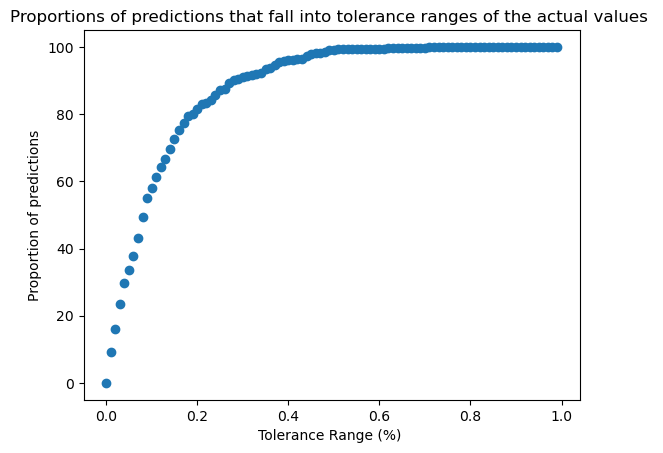

In [661]:
y_test_pred = model.predict(X_test)

acc = [prediction_accuracy(torch.tensor(y_test_pred), y_test, x) for x in np.arange(0,1,0.01)]

plt.scatter(x=np.arange(0,1,0.01), y=acc)
plt.ylabel("Proportion of predictions")
plt.xlabel("Tolerance Range (%) ")
plt.title("Proportions of predictions that fall into tolerance ranges of the actual values ")


one_percent = prediction_accuracy(torch.tensor(y_test_pred), y_test, 0.01)
five_percent = prediction_accuracy(torch.tensor(y_test_pred), y_test, 0.05)
ten_percent = prediction_accuracy(torch.tensor(y_test_pred), y_test, 0.10)
twenty_percent = prediction_accuracy(torch.tensor(y_test_pred), y_test, 0.2)
print(f"Percent of predicted pIC/pEC values within 1% of actual value: {one_percent}%")
print(f"Percent of predicted pIC/pEC values within 5% of actual value: {five_percent}%")
print(f"Percent of predicted pIC/pEC values within 10% of actual value: {ten_percent}%")
print(f"Percent of predicted pIC/pEC values within 20% of actual value: {twenty_percent}%")

## RF --> Find chemical motifs that are important 

- 1) Find the important features from the random forest and plot 
- 2) Made a new functions --> 
        - smiles_to_fingerprint_and_info: saves bit info along wit fingerprint (similar to before)
        - bit_to_motif: find specific motifs that are important in random forest

Maps the results of the RF model back to the ligand's chemical structure. It showcases the top 10 most impactful fingerprint indexes (or motifs) in RF decision making. This allows for further studies into the specific location of the motifs and how it interplays with the CFTR in docking. 

- From looking at the top  10 common motifs, it seems like they are all carbon-carbon bonds or carbon- Oxygen or carbon-nitrogen bonds. 
- It seems like there is a preference for highly electronegaitve and polar elements (N, O)
- 6/10 were carbon-carbon bonds, 2 were single, 4 were double. 
- 3/10 contained O-C 
- 1/10 contained N 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'Feature 472'),
  Text(1, 0, 'Feature 694'),
  Text(2, 0, 'Feature 164'),
  Text(3, 0, 'Feature 114'),
  Text(4, 0, 'Feature 201'),
  Text(5, 0, 'Feature 416'),
  Text(6, 0, 'Feature 771'),
  Text(7, 0, 'Feature 795'),
  Text(8, 0, 'Feature 548'),
  Text(9, 0, 'Feature 128'),
  Text(10, 0, 'Feature 113'),
  Text(11, 0, 'Feature 792'),
  Text(12, 0, 'Feature 511'),
  Text(13, 0, 'Feature 910'),
  Text(14, 0, 'Feature 433'),
  Text(15, 0, 'Feature 873'),
  Text(16, 0, 'Feature 234'),
  Text(17, 0, 'Feature 772'),
  Text(18, 0, 'Feature 490'),
  Text(19, 0, 'Feature 20'),
  Text(20, 0, 'Feature 809')])

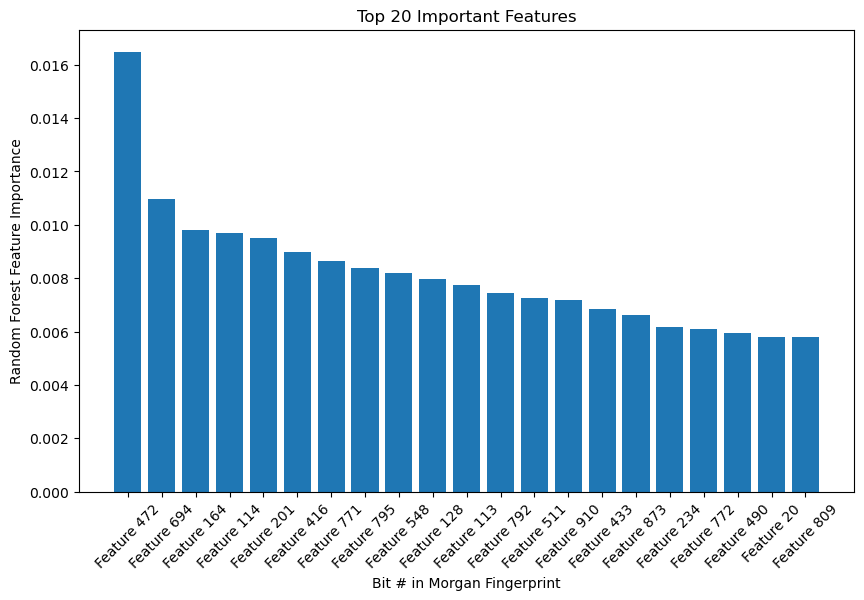

In [662]:
# Features will be fingerprint at 1024 and 2 radius 
X = np.array(list(cftr_all['Fingerprint']))

# Value we hope to predict plog Bioactivity values 
y = cftr_all["p_log_values (M)"].values 

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestRegressor(n_estimators = 512, max_depth=50, max_features ='sqrt', random_state=42)

model.fit(X_train, y_train)

# Find the most important features (how much they contribute to the predict power of the model)
impt_features = model.feature_importances_

# Save the feature names (index of bit) as a dictionary along with the feature importance 
feat_index =dict(zip(range(X_train.shape[1]),impt_features ))
# sort the features accoring to the importance 
sorted_index = sorted(feat_index.items(), key=lambda x: x[1], reverse=True)
# save only the indices
sorted_indices = [index for index, importance in sorted_index]


# for plotting labels (need to be a string)
sorted_feature_names = [f'Feature {index}' for index in sorted_indices]

#Plot 
plt.figure(figsize=(10, 6))
plt.title("Top 20 Important Features")
plt.bar([sorted_feature_names[i] for i in range(21)], [sorted_index[i][1] for i in range(21)])
plt.xlabel("Bit # in Morgan Fingerprint")
plt.ylabel("Random Forest Feature Importance")
plt.xticks(rotation=45)


In [664]:
def smiles_to_fingerprint_and_info(smiles, radius=2, n_bits=1024):
    """
    Updated Smiles function to include information about the bits.  
    bitInfo : provides details about which specific atoms and bonds contribute to the bit

    Inputs: 
        - Smiles, radius, n_bits=1024
    Outputs: 
        - Morgan Fingerptint and bitInfo

    """
    molecule = Chem.MolFromSmiles(smiles)
    info = {}
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=n_bits, bitInfo=info)
    return list(fingerprint), info

def bit_to_motif(smiles, bit, radius=2):
    """
    map the bit from chemical fingerprint back to the motif it represents. 

    Inputs: 
        - Smiles, Bit, radius =2
    Outputs: 
        - sub_mol : the specific motif highlighted by the bit 
        - or None : bit not present in structure. 
    """
    # Convert the smiles to molecules
    molecule = Chem.MolFromSmiles(smiles)

    # save the fingerprint and info from returned from the function 
    fingerprint, info = smiles_to_fingerprint_and_info(smiles, radius, n_bits=1024)

    # if specific bit of interest is not present in this molecule
    if bit not in info:
        return None  

    # Extract atom indices that are involved in this bit
    atom_indices = set()
    for atom_idx, radius in info[bit]:
        atom_indices.add(atom_idx)

    # Highlight the substructure in the molecule
    sub_mol = Chem.PathToSubmol(molecule, list(atom_indices))

    return sub_mol



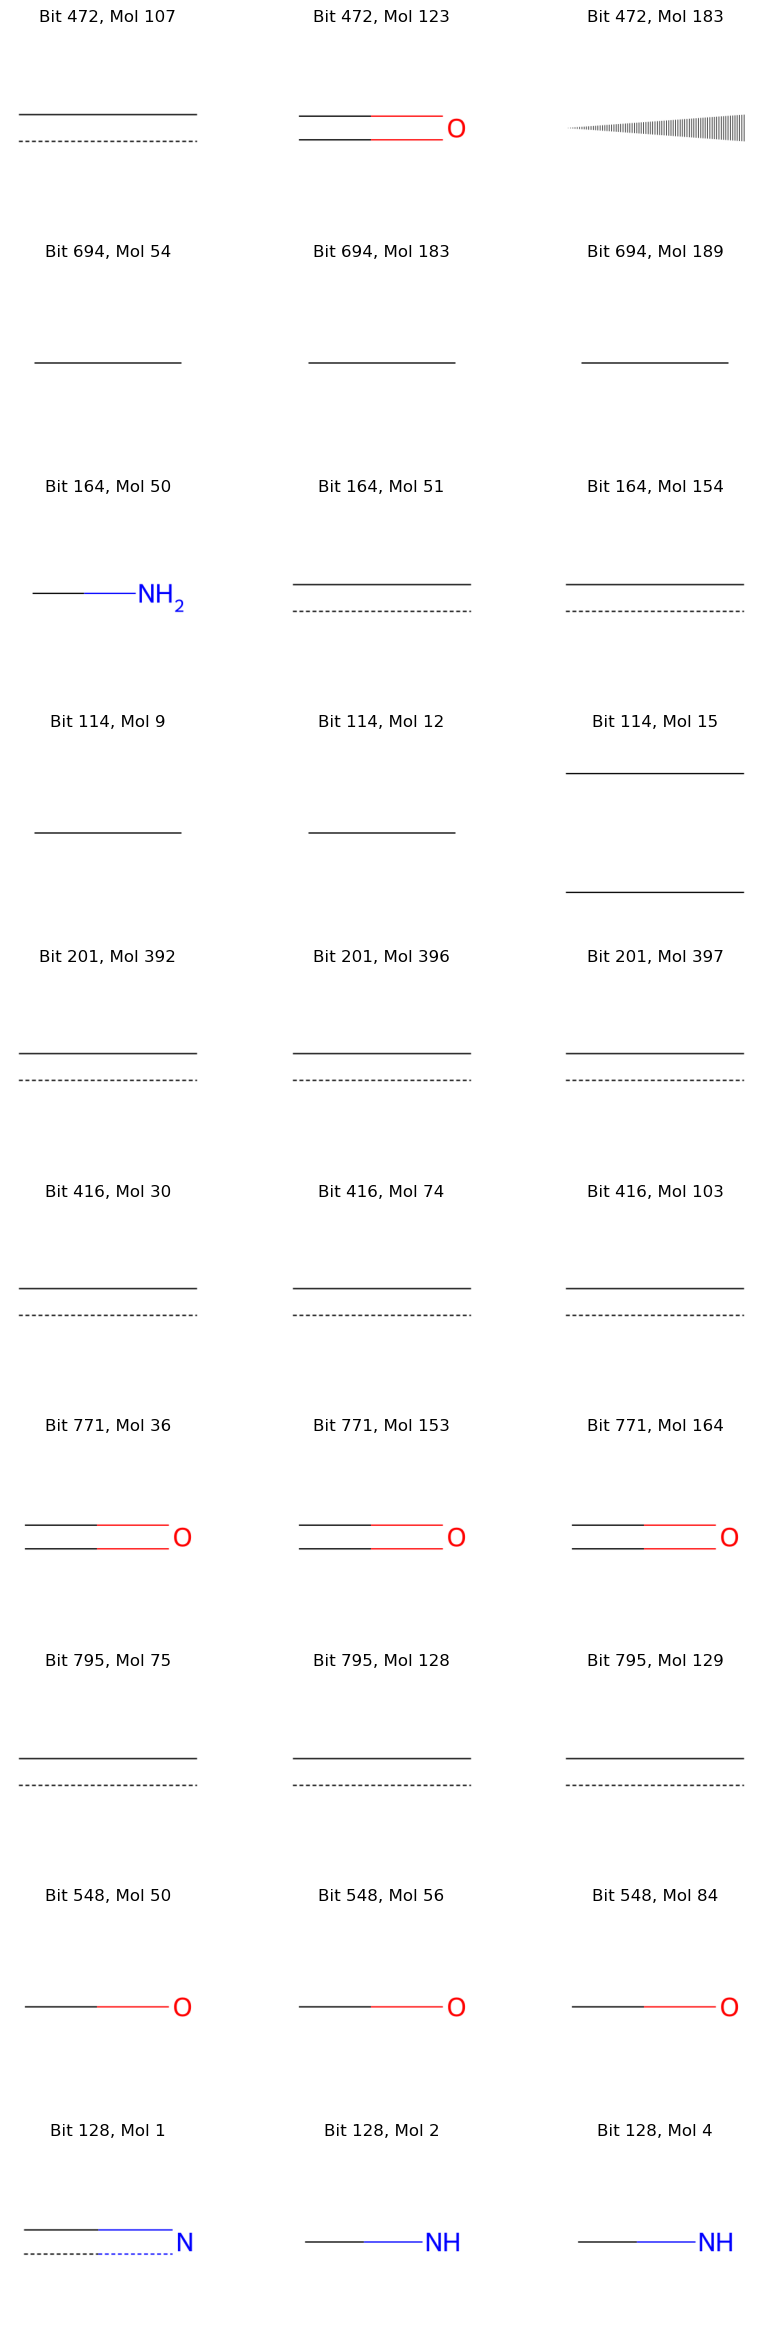

In [665]:
# Inferred from graph
important_bits = sorted_indices[0:10]

# For subplot 
fig, axes = plt.subplots(len(important_bits), 3, figsize=(10, len(important_bits) * 3))

for i, bit in enumerate(important_bits):
    count = 0
    for j, smiles in enumerate(cftr_all['SMILES']):
        # translate finger print bits to motif 
        substructure = bit_to_motif(smiles, bit)
        # if substructure is present
        if substructure is not None:
            # draw image from molecules  
            img = Draw.MolToImage(substructure)
            ax = axes[i, count] if len(important_bits) > 1 else axes[count]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Bit {bit}, Mol {j}')
            count += 1
            # print only 3, enough to resolve differences. 
            if count >= 3:
                break

# 5) Test Models - Implement a Virtual Screen. 

- I tried to find an Assay that I could use to test out my model on a set of unknown ligands. 
- Cool enough, I found a paper by my lab! 
    - Source: N.D. Sonawane, A.S. Verkman,Thiazolidinone CFTR inhibitors with improved water solubility identified by structure–activity analysis,Bioorganic & Medicinal Chemistry,Volume 16, Issue 17,2008,Pages 8187-8195, ISSN 0968-0896, https://doi.org/10.1016/j.bmc.2008.07.044

## Virtual Screen - Preprocess Data 

- Read CSV files

In [430]:
# Screen! 
# Data from Chembl with all the IDs of the ligands tested in the V assay
screen = pd.read_csv("screen_chembl.csv", sep=';')
screen.head()

# IC50 values from paper along with the CHEMBL ID that I matched from Chembl 
screen_ic = pd.read_csv("Screen_IC50.csv")
screen_ic.head()

,IC50 (μM),CHEMBL ID
0,0.4,CHEMBL461939
1,0.8,CHEMBL461940
2,1.4,CHEMBL461375
3,1.5,CHEMBL460075
4,1.5,CHEMBL461759


### VS - PreProcess Data merge data set and set an arbritary value for inactive compounds: 

This screen also contains some inactive compounds that are have Ic50 or ec50 of > 50uM. 

Let's assume that this value is 100uM 

Screen of 50 compounds

In [438]:
test_screen = screen.merge(screen_ic,left_on= "ChEMBL ID"	,right_on="CHEMBL ID ")

test_screen.loc[test_screen["IC50 (μM)"] == "Inactive", "IC50 (μM)"] = 100

print(len(test_screen))

test_screen.head()


50


,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Np Likeness Score,Molecular Species,Molecular Formula,Smiles,Inchi Key,IC50 (μM),CHEMBL ID
0,CHEMBL486671,NaN,NaN,Small molecule,NaN,413.40,1,1,4.23,81.00,...,3,0,413.0003,-1.42,NEUTRAL,C17H10F3NO4S2,O=C1/C(=C/c2ccc(O)c(O)c2O)SC(=S)N1c1cccc(C(F)(...,ZHXNSAUKDCLEDQ-SDQBBNPISA-N,28,CHEMBL486671
1,CHEMBL461941,NaN,NaN,Small molecule,NaN,439.44,1,1,4.57,66.84,...,1,0,439.0160,-1.86,ACID,C19H12F3NO4S2,O=C(O)COc1ccc(/C=C2\SC(=S)N(c3cccc(C(F)(F)F)c3...,XJFRAEDSGSGUPC-NVNXTCNLSA-N,2.6,CHEMBL461941
2,CHEMBL450222,NaN,NaN,Small molecule,NaN,355.44,1,1,4.10,57.61,...,1,0,355.0337,-1.73,ACID,C18H13NO3S2,Cc1cccc(N2C(=O)/C(=C/c3ccc(C(=O)O)cc3)SC2=S)c1,OLZKVXPTDFNASH-GDNBJRDFSA-N,5,CHEMBL450222
3,CHEMBL461575,NaN,NaN,Small molecule,NaN,369.47,1,1,4.41,57.61,...,1,0,369.0493,-1.46,ACID,C19H15NO3S2,Cc1cccc(N2C(=O)/C(=C/c3ccc(C(=O)O)cc3)SC2=S)c1C,BRKYTJFUNROSCM-YBEGLDIGSA-N,7,CHEMBL461575
4,CHEMBL488016,NaN,NaN,Small molecule,NaN,425.41,1,1,4.52,77.84,...,2,0,425.0003,-1.38,ACID,C18H10F3NO4S2,O=C(O)c1cc(/C=C2\SC(=S)N(c3ccc(C(F)(F)F)cc3)C2...,DMIWVWYKHHMBIN-ZSOIEALJSA-N,25,CHEMBL488016


### VS - Preprocess - Remove Duplicates, add fingerprints. 
- remove duplicates 
- add fingerprint 

In [439]:
# Remove Duplicates 
print(f"screen size before dropping duplicate inchi key: {len(test_screen)}")

# inchi key duplicates
test_screen= test_screen.drop_duplicates(subset="Inchi Key")

print(f"screen size after dropping duplicate inchi key: {len(test_screen)}")


test_screen = test_screen.drop_duplicates()

print(f"screen size after dropping all duplicates : {len(test_screen)}")

screen size before dropping duplicate inchi key: 50
screen size after dropping duplicate inchi key: 50
screen size after dropping all duplicates : 50


In [440]:
# Add fingerprint and convert the IC50 values to floats as well as pIC50 Values. 
test_screen['Fingerprint'] = test_screen['Smiles'].apply(smiles_to_fingerprint)
test_screen['IC50 (μM)'] = [float(i) for i in test_screen['IC50 (μM)'] ]
test_screen["pIC(M)"] = -np.log10(test_screen["IC50 (μM)"] *(10e-6))

test_screen.head()


,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,Molecular Weight (Monoisotopic),Np Likeness Score,Molecular Species,Molecular Formula,Smiles,Inchi Key,IC50 (μM),CHEMBL ID,Fingerprint,pIC(M)
0,CHEMBL486671,NaN,NaN,Small molecule,NaN,413.40,1,1,4.23,81.00,...,413.0003,-1.42,NEUTRAL,C17H10F3NO4S2,O=C1/C(=C/c2ccc(O)c(O)c2O)SC(=S)N1c1cccc(C(F)(...,ZHXNSAUKDCLEDQ-SDQBBNPISA-N,28.0,CHEMBL486671,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.552842
1,CHEMBL461941,NaN,NaN,Small molecule,NaN,439.44,1,1,4.57,66.84,...,439.0160,-1.86,ACID,C19H12F3NO4S2,O=C(O)COc1ccc(/C=C2\SC(=S)N(c3cccc(C(F)(F)F)c3...,XJFRAEDSGSGUPC-NVNXTCNLSA-N,2.6,CHEMBL461941,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.585027
2,CHEMBL450222,NaN,NaN,Small molecule,NaN,355.44,1,1,4.10,57.61,...,355.0337,-1.73,ACID,C18H13NO3S2,Cc1cccc(N2C(=O)/C(=C/c3ccc(C(=O)O)cc3)SC2=S)c1,OLZKVXPTDFNASH-GDNBJRDFSA-N,5.0,CHEMBL450222,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.301030
3,CHEMBL461575,NaN,NaN,Small molecule,NaN,369.47,1,1,4.41,57.61,...,369.0493,-1.46,ACID,C19H15NO3S2,Cc1cccc(N2C(=O)/C(=C/c3ccc(C(=O)O)cc3)SC2=S)c1C,BRKYTJFUNROSCM-YBEGLDIGSA-N,7.0,CHEMBL461575,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.154902
4,CHEMBL488016,NaN,NaN,Small molecule,NaN,425.41,1,1,4.52,77.84,...,425.0003,-1.38,ACID,C18H10F3NO4S2,O=C(O)c1cc(/C=C2\SC(=S)N(c3ccc(C(F)(F)F)cc3)C2...,DMIWVWYKHHMBIN-ZSOIEALJSA-N,25.0,CHEMBL488016,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.602060


## VS - Test out models 
1) ANN 
2) RF 

In [441]:
# Standardize the values in the test_screen.
scaler =StandardScaler()
X_screen = np.array(list(test_screen['Fingerprint']))
X_screen = scaler.fit_transform(X_screen)

# Actual experimental values of the ligands. 
Y_pic = test_screen["pIC(M)"]

## ANN Virtual Screen 

- Implementing the ANN on the Test screen

Results: 
- Virtual Screen mse: 1.081829208759805, 
- Virtual Screen rmse: 1.0401101906816435
- Correlation coefficient: 0.45254041021370744

The mse/rmse is fairly high when compared to the test set previously. However, the correlation coefficient is 0.45 which means there exist some positive correlation between the predicted and actual values. Even though the residual plot seems non directionaly skewed, there is more points below than above 0 which indicates that this model is overpredicting (actual-pred <0 --> actual < pred). This can also be inferred from the smaller slope of my line of best fit that is so more run over rise (x>y). 

  0%|          | 0/100 [00:00<?, ?it/s]

Virtual Screen mse: 1.1085111579786966, Virtual Screen rmse: 1.052858565040289
Correlation coefficient: 0.45254041021370744


Text(0, 0.5, 'Residuals')

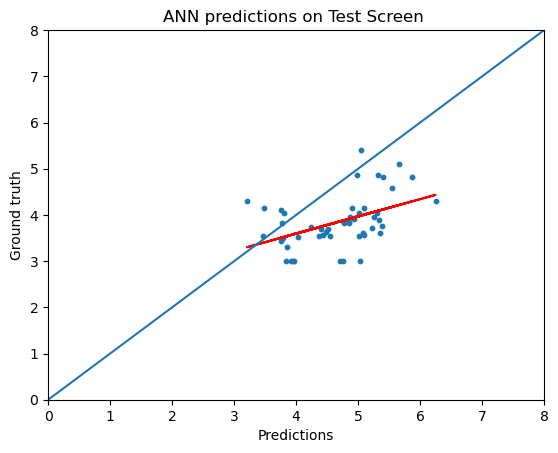

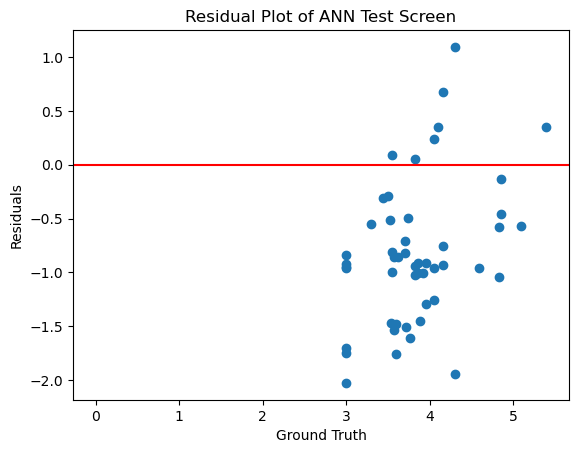

In [675]:
# Train Model on Training Data from before. 

# Features will be fingerprint at 1024 and 2 radius 
X = np.array(list(cftr_all['Fingerprint']))
# Value we hope to predict plog Bioactivity values 
y = cftr_all["p_log_values (M)"].values 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# list to save the predictions from multiple runs 
predictions_list=[]
# run model 5 times, save the screen predictions 
for i in range(5): 
    # establish model
    model_ann = ANN_paper(1024)
    # train_test_split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    # set up trainer and train model
    trainer_ann = Trainer(model_ann, optimizer_type="adam", learning_rate=1e-5, epoch=100, batch_size=100)
    trained_ann = trainer_ann.train(X_train, y_train , X_test, y_test,l2=True, silent=True)
    # predict the X_screen values based on a learned model 
    pred_screen= trainer_ann.predict(X_screen)
    # append these predictions to the list.
    predictions_list.append(np.asanyarray(pred_screen))

# find the mean of the predictions, by columns 
mean_predictions= np.mean(predictions_list, axis=0)
# find metrics 
mse = mean_squared_error(mean_predictions, Y_pic)
rmse = np.sqrt(mse)
# add the predicitons as a column in the main test_screen dateset. 
test_screen["ANN_Pred"] = mean_predictions

print(f"Virtual Screen mse: {mse}, Virtual Screen rmse: {rmse}")

# show correlation function 
show_correlation(mean_predictions,Y_pic)
plt.title("ANN predictions on Test Screen ")
plt.axline((0, 0), slope=1)
plt.xlim(0,8)
plt.ylim(0,8)

#Residual plot 
residuals = Y_pic-mean_predictions
plt.figure()
plt.scatter(Y_pic,residuals)
plt.axline((0,0), slope=0, color='red')
plt.title("Residual Plot of ANN Test Screen")
plt.xlabel("Ground Truth")
plt.ylabel("Residuals")

## RF Virtual Screen 

- implementing RF on the test screen. 

Results 
- Virtual Screen mse: 0.39646747076984, 
- Virtual Screen rmse: 0.6296566292590272
- Correlation coefficient: 0.035550175799226855

Comparetively, to ANN, these mse/rmse values are much smaller. However, the correlation coefficiet is very low. Indicating that there is little relationship between my predicted and actual values. 

The residual plot is highly skewed, the point are positively correlated. This implies that the model is overestimating the smaller pIC50 but underestimating the larger pIC50. This implies that this model is producing very similar values for all the ligands. Which is confirmed by viewing the correlation graph where the predictions all exist in a very small range. This is probably because the ligands from the test screen are very very similar. 

Virtual Screen mse: 0.39646747076984, Virtual Screen rmse: 0.6296566292590272
Correlation coefficient: 0.035550175799226855


Text(0, 0.5, 'Residuals')

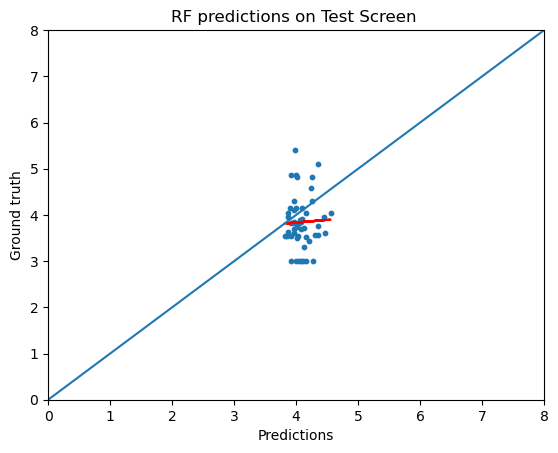

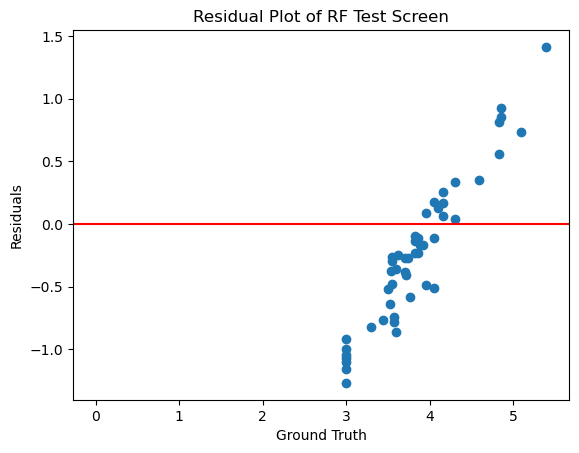

In [672]:
# Train Model on Training Data from before. 
# Features will be fingerprint at 1024 and 2 radius 
X = np.array(list(cftr_all['Fingerprint']))

# Value we hope to predict plog Bioactivity values 
y = cftr_all["p_log_values (M)"].values 

scaler = StandardScaler()
X = scaler.fit_transform(X)

predictions_list_rf =[]
for i in range(5): 
    # establish model
    model_RF = RandomForestRegressor(n_estimators = 512, max_depth=50, max_features ='sqrt', random_state=42)
    # train_test_split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    # Set up model and fit data 
    model_RF.fit(X_train, y_train)
    # predict the screen values based on the learned model. 
    y_screen_pred = model_RF.predict(X_screen)
    # append these predictions to the list.
    predictions_list_rf.append(np.asanyarray(y_screen_pred))

# find the mean of the predictions
mean_predictions_rf= np.mean(predictions_list_rf, axis=0)
# find metrics 
mse = mean_squared_error(mean_predictions_rf, Y_pic)
rmse = np.sqrt(mse)
# add the predicitons as a column in the main test_screen dateset. 
test_screen["RF_Pred"] = mean_predictions_rf

print(f"Virtual Screen mse: {mse}, Virtual Screen rmse: {rmse}")

# show correlation function 
show_correlation(mean_predictions_rf,Y_pic)
plt.title("RF predictions on Test Screen ")
plt.axline((0, 0), slope=1)
plt.xlim(0,8)
plt.ylim(0,8)

# Residual plot 
residuals = Y_pic-mean_predictions_rf
plt.figure()
plt.scatter(Y_pic,residuals)
plt.axline((0,0), slope=0, color='red')
plt.title("Residual Plot of RF Test Screen")
plt.xlabel("Ground Truth")
plt.ylabel("Residuals")

## Compare Models 

- Breaking up the data frame into 
    - Binders --> "Strong" --> IC50 <= 10uM 
    - Weak or non-binders --> "Weak" --> IC50 > 50uM 
    - Inbetween --> Others ---> 50uM >IC50 > 10uM 
- Results (graphs shown below): 

ANN: 
- Virtual Screen STRONG mse: 0.8525559918395732, Virtual Screen STRONG rmse: 0.9233395864142148
- Virtual Screen Weak mse: 1.9069633554575767, Virtual Screen Weak rmse: 1.38092843965847

RF: 
- Virtual Screen STRONG mse: 0.36003928517547334, Virtual Screen STRONG rmse: 0.6000327367531486
- Virtual Screen Weak mse: 1.1151175583136879, Virtual Screen Weak rmse: 1.0559912681048493

The mse/rmse values are smaller in both the Strong and Weak groups for the RF model. However, from what we discussed above, this seems to be because the values are all very similar. Whereas the ANN tends to overpredict randomly, causing RMSE values to be higher. 

Since the model is trained primarily on strong binders, it makes sense that the mse/rmse values for weak binders is higher in both RF and ANN. 

Also, its very interesting how ANN was able to preidct a wider range of values for nonbinders, while RF had similar predictions for non-binders. However, RF in general, just predicted values ~4 for all the molecules in the test_screen. 

ANN: 
Virtual Screen STRONG mse: 0.7860599573575375, Virtual Screen STRONG rmse: 0.88660022409062
Virtual Screen Weak mse: 1.72153361314276, Virtual Screen Weak rmse: 1.3120722591163796

 RF: 
Virtual Screen STRONG mse: 0.36003928517547334, Virtual Screen STRONG rmse: 0.6000327367531486
Virtual Screen Weak mse: 1.1151175583136879, Virtual Screen Weak rmse: 1.0559912681048493


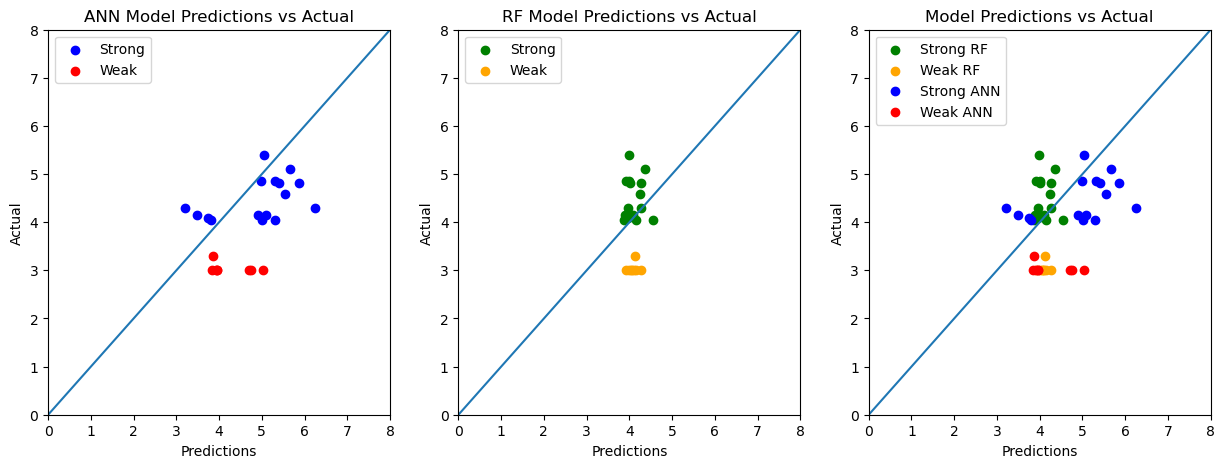

In [677]:
# Seperate data frames into 3 categories 
test_screen_weak = test_screen[(test_screen["IC50 (μM)"]>=50)==True]
test_screen_strong = test_screen[(test_screen["IC50 (μM)"]<=10)==True]
test_screen_others = test_screen_in_between = test_screen[test_screen["IC50 (μM)"].between(10, 50, inclusive="neither")]

# plot the ann weak/strong binders 
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(test_screen_strong["ANN_Pred"],test_screen_strong["pIC(M)"], color ="blue", label="Strong")
plt.scatter(test_screen_weak["ANN_Pred"],test_screen_weak["pIC(M)"], color ="Red", label="Weak")
plt.title("ANN Model Predictions vs Actual")
plt.legend()
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.xlim(0,8)
plt.ylim(0,8)
plt.axline((0, 0), slope=1)

# plot the rf weak/strong binders 
plt.subplot(1,3,2)
plt.scatter(test_screen_strong["RF_Pred"],test_screen_strong["pIC(M)"], color ="green", label="Strong")
plt.scatter(test_screen_weak["RF_Pred"],test_screen_weak["pIC(M)"], color ="orange", label="Weak")
plt.title("RF Model Predictions vs Actual")
plt.legend()
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.xlim(0,8)
plt.ylim(0,8)
plt.axline((0, 0), slope=1)

# plot both weak/strong binders 
plt.subplot(1,3,3)
plt.scatter(test_screen_strong["RF_Pred"],test_screen_strong["pIC(M)"], color ="green", label="Strong RF")
plt.scatter(test_screen_weak["RF_Pred"],test_screen_weak["pIC(M)"], color ="orange", label="Weak RF")
plt.scatter(test_screen_strong["ANN_Pred"],test_screen_strong["pIC(M)"], color ="blue", label="Strong ANN")
plt.scatter(test_screen_weak["ANN_Pred"],test_screen_weak["pIC(M)"], color ="Red", label="Weak ANN")
plt.xlim(0,8)
plt.ylim(0,8)
plt.axline((0, 0), slope=1)
plt.title("Model Predictions vs Actual")
plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.legend()

# ANN metrics 
print("ANN: ")
test_screen_strong = test_screen[(test_screen["IC50 (μM)"]<=10)==True]
mse = mean_squared_error(test_screen_strong["ANN_Pred"], test_screen_strong["pIC(M)"])
rmse = np.sqrt(mse)
print(f"Virtual Screen STRONG mse: {mse}, Virtual Screen STRONG rmse: {rmse}")

mse = mean_squared_error(test_screen_weak["ANN_Pred"], test_screen_weak["pIC(M)"])
rmse = np.sqrt(mse)
print(f"Virtual Screen Weak mse: {mse}, Virtual Screen Weak rmse: {rmse}")


# RF metrics 
print("\n RF: ")
mse = mean_squared_error(test_screen_strong["RF_Pred"], test_screen_strong["pIC(M)"])
rmse = np.sqrt(mse)
print(f"Virtual Screen STRONG mse: {mse}, Virtual Screen STRONG rmse: {rmse}")

mse = mean_squared_error(test_screen_weak["RF_Pred"], test_screen_weak["pIC(M)"])
rmse = np.sqrt(mse)
print(f"Virtual Screen Weak mse: {mse}, Virtual Screen Weak rmse: {rmse}")

## Relay This back to the 10 important motifs from the random forest 

In [678]:
def count_active_bits(smiles, bits, radius=2, n_bits=1024):
    """
    Counts the number of times the specific fingerprint bit is present in the molecules
    Inputs: 
        - smiles : (list or np.array) smiles of molecules 
        - bits : (list or np.array) bits of interest
        - radius, n_bits
    Outputs: 
        - bit_counts : (dictionary) that stores the abundance of each bit in bits in the smile in smiles
    """
    bit_counts = {bit: 0 for bit in bits}
    
    for smile in smiles:
        molecule = Chem.MolFromSmiles(smile)
        if molecule is None:
            continue  # Skip invalid SMILES strings
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=n_bits)
        
        for bit in bits:
            if fingerprint[bit]:
                bit_counts[bit] += 1

    return bit_counts


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, '472'),
  Text(1, 0, '694'),
  Text(2, 0, '164'),
  Text(3, 0, '114'),
  Text(4, 0, '201'),
  Text(5, 0, '416'),
  Text(6, 0, '771'),
  Text(7, 0, '795'),
  Text(8, 0, '548'),
  Text(9, 0, '128'),
  Text(10, 0, '113'),
  Text(11, 0, '792'),
  Text(12, 0, '511'),
  Text(13, 0, '910'),
  Text(14, 0, '433'),
  Text(15, 0, '873'),
  Text(16, 0, '234'),
  Text(17, 0, '772'),
  Text(18, 0, '490'),
  Text(19, 0, '20')])

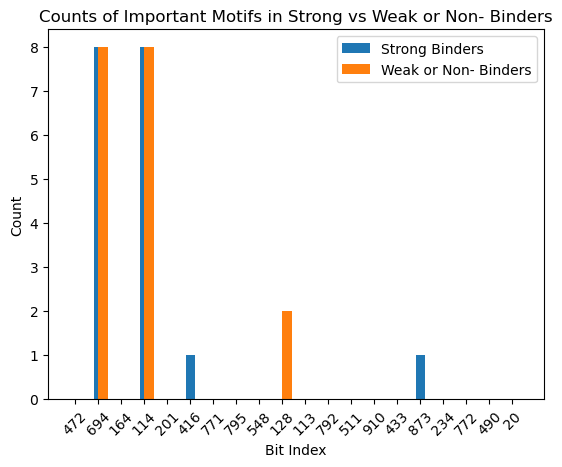

In [682]:
# From above, copied here, the important bits from RF REGRESSION MODEL
important_bits = sorted_indices[0:20]

# Apply the count function to count the number of times each of these important bits 
# appears in the data set 
top_8_strong = test_screen_strong.sort_values(by="IC50 (μM)").iloc[:len(test_screen_weak)]

count_strong = count_active_bits(top_8_strong["Smiles"], important_bits)
count_weak = count_active_bits(test_screen_weak["Smiles"], important_bits)

# the df are different sizes but they should always be the same 
assert(len(count_strong)== len(count_weak))

# create arrays/lists for plotting 
bits = list(count_strong.keys())
counts_strong = np.array([count_strong[bit] for bit in bits])
counts_weak = np.array([count_weak[bit] for bit in bits])

# plot 
plt.bar(range(len(bits)), counts_strong, width=0.4, label='Strong Binders', align='center')
plt.bar(range(len(bits)), counts_weak, width=0.4, label='Weak or Non- Binders', align='edge')
plt.xlabel('Bit Index')
plt.ylabel('Count')
plt.xticks(range(len(bits)), bits)
plt.legend()
plt.title('Counts of Important Motifs in Strong vs Weak or Non- Binders')
plt.xticks(rotation=45)


# Discussion: 

- Overall, I think this was a great starting point for establishing a Virtual Screen method. 
- Both methods seemed to be successful at learing the training set data and fairly accurate at predicting the test data. 
- Key Comparisons: 

Multiple R^2 of test set: 
- RF:  0.5531008376300917
- ANN: 0.8849965768226823

RMSE/MSE of test set: 
- RF: MSE: 0.4688257171065882, RMSE: 0.6847084906050079
- ANN: MSE: 0.6917089819908142 RMSE: 0.8316904363949451
- Even though the RF model resulted in the lower MSE/RMSE values, it is clear from our previous discussion that the ANN was a better model. This is shown through the R^2 value of the test set data where the ANN was much closer to 1 than RF. This implies that the ANN model is able to explain 80% of the variance in the observations (fingerprints) whereas RF was only able to explain 50% of it. 

- I believe that much more can be done to improve this model. 
- I focused on Ligand-Based Method. But a 3D receptor based model is also possible. 
- Additional parameters can be added beyond the fingerprints, including docking simulations, 3D-shape similarity, electrostatic, etc. 
- In relation to CFTR, a lot of studies have been done regarding this receptor and most believe that the effective drugs are able to stablize the mis-functioning CFTR protein. Hence, I belive that an addition of 3d receptor based model would add a lot of value to this current project. 

If I had the time to continue this project: 
- Improve RF model to stop overfitting
- Use Data Warrior to study the common motifs of the strong inhibitors in the training data set to improve the weight calculations in both models. 

# Thank you :-) 

THANK Y'ALL SO MUCH FOR AN AWESOME SEMESTER !!! Y'all were so supportive and kind. 

I truly learned so much and I'm very excited to say that I can machine learn now !!! 

# References : 

### CFTR Sources:
N.D. Sonawane, A.S. Verkman,Thiazolidinone CFTR inhibitors with improved water solubility identified by structure–activity analysis,Bioorganic & Medicinal Chemistry,Volume 16, Issue 17,2008,Pages 8187-8195, ISSN 0968-0896, https://doi.org/10.1016/j.bmc.2008.07.044.

Corradi V, Vergani P, Tieleman DP. Cystic Fibrosis Transmembrane Conductance Regulator (CFTR): CLOSED AND OPEN STATE CHANNEL MODELS. J Biol Chem. 2015 Sep 18;290(38):22891-906. doi: 10.1074/jbc.M115.665125. Epub 2015 Jul 30. PMID: 26229102; PMCID: PMC4645605.

Mechanism of CFTR correction by type I folding correctors. Karol Fiedorczuk, Jue Chen. bioRxiv 2021.06.18.449063; doi: https://doi.org/10.1101/2021.06.18.449063

### ANN/RF Sources: 

Jiaying You, Robert D. McLeod, Pingzhao Hu, Predicting drug-target interaction network using deep learning model, Computational Biology and Chemistry, Volume 80, 2019, Pages 90-101,ISSN 1476-9271,https://doi.org/10.1016/j.compbiolchem.2019.03.016.


Lind AP, Anderson PC. Predicting drug activity against cancer cells by random forest models based on minimal genomic information and chemical properties. PLoS One. 2019 Jul 11;14(7):e0219774. doi: 10.1371/journal.pone.0219774. PMID: 31295321; PMCID: PMC6622537.


Franky. “Basic Molecular Representation for Machine Learning.” Medium, Towards Data Science, 20 Sept. 2021, towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76. 


Ashwin Dhakal, Cole McKay, John J Tanner, Jianlin Cheng, Artificial intelligence in the prediction of protein–ligand interactions: recent advances and future directions, Briefings in Bioinformatics, Volume 23, Issue 1, January 2022, bbab476, https://doi.org/10.1093/bib/bbab476


Gimeno A, Ojeda-Montes MJ, Tomás-Hernández S, Cereto-Massagué A, Beltrán-Debón R, Mulero M, Pujadas G, Garcia-Vallvé S. The Light and Dark Sides of Virtual Screening: What Is There to Know? Int J Mol Sci. 2019 Mar 19;20(6):1375. doi: 10.3390/ijms20061375. PMID: 30893780; PMCID: PMC6470506.

Rogers D, Hahn M. Extended-connectivity fingerprints. J Chem Inf Model. 2010 May 24;50(5):742-54. doi: 10.1021/ci100050t. PMID: 20426451.

### DataBases Sources: 


ChemBL: Gaulton A, Bellis LJ, Bento AP, Chambers J, Davies M, Hersey A, Light Y, McGlinchey S, Michalovich D, Al-Lazikani B, Overington JP. ChEMBL: a large-scale bioactivity database for drug discovery. Nucleic Acids Res. 2012 Jan;40(Database issue):D1100-7. doi: 10.1093/nar/gkr777. Epub 2011 Sep 23. PMID: 21948594; PMCID: PMC3245175.


BindingDB: Liu T, Lin Y, Wen X, Jorissen RN, Gilson MK. BindingDB: a web-accessible database of experimentally determined protein-ligand binding affinities. Nucleic Acids Res. 2007 Jan;35(Database issue):D198-201. doi: 10.1093/nar/gkl999. Epub 2006 Dec 1. PMID: 17145705; PMCID: PMC1751547.





